# Data Analysis, Linear Regression and Model Comparison 

In this notebook we are going to consider historical measurements of water quality data coming from a surface water station in Berlin.

First, we need to import the necessary libraries to load and handle data.

In [312]:
import os
import pandas as pd
import numpy as np

In [313]:
np.random.seed(42) # to make this notebook's output reproducible across runs

In [314]:
# Set the data path
data_path = "data"

Let's use pandas to load the data into a **pandas.DataFrame**.
Since we received three csv files, one for measurements regarding water quality parameters, one for flow rate measurements and one for rain precipitations, we are going to load three csv files in three separate pandas.DataFrame that we are going to merge later.

In [315]:
ts_sw_df = pd.read_csv(
    os.path.join(
        data_path, "time-series_surface-water_quality.csv"
    )
)
flow_df = pd.read_csv(
    os.path.join(
        data_path, "time-series_surface-water_flow.csv"
    )
)

Let's have a first look at the datasets.

In [316]:
ts_sw_df.head()

Messstelle  Messstellennummer  ... Einheit Bestimmungsgrenze
0  Dämeritzsee - Seemitte                105  ...    mg/l               NaN
1  Dämeritzsee - Seemitte                105  ...    mg/l               NaN
2  Dämeritzsee - Seemitte                105  ...    mg/l               NaN
3  Dämeritzsee - Seemitte                105  ...    mg/l               NaN
4  Dämeritzsee - Seemitte                105  ...    mg/l               NaN

[5 rows x 10 columns]

In [317]:
flow_df.head()

Messstellennummer   Parameter Einheit       Datum  Tagesmittelwert
0            5827101  Durchfluss    m³/s  2016-04-12             4.58
1            5827101  Durchfluss    m³/s  2016-04-13             4.42
2            5827101  Durchfluss    m³/s  2016-04-14             4.95
3            5827101  Durchfluss    m³/s  2016-04-15             5.45
4            5827101  Durchfluss    m³/s  2016-04-16             6.74

In order to understand them, it could be helpful to translate them to english :)

In [318]:
ts_sw_df.rename(
    columns={
        "Messstelle": "Station",
        "Messstellennummer": "Station ID",
        "Datum": "DateTime",
        "Einheit": "Unit",
        "Wert": "Value",
    },
    inplace=True,
)

# Drop unnecessary columns
ts_sw_df.drop(
    columns=[
        "Entnahmetiefe [m]",
        "Messmethode",
        "Vorzeichen",
        "Bestimmungsgrenze",
    ],
    inplace=True,
)

In [319]:
# Define the translation dictionary for the variables we are interested in
variables_mapping = {
    "Lufttemperatur": "Air Temperature (°C)",
    "Wassertemperatur": "Water Temperature (°C)",
    "Leitfähigkeit": "Conductivity (µS/cm)",
    "Ammonium-Stickstoff": "Ammonium (mg/l)",
    "Nitrat-Stickstoff": "Nitrate (mg/l)",
    "pH-Wert": "pH",
    "DOC (Gelöster organischer Kohlenstoff)": "DOC (mg/l)",
    "Sauerstoff-Gehalt": "Dissolved Oxygen (mg/l)",
}
# Filter the data frame to only include the variables we are interested in
ts_sw_df = ts_sw_df[ts_sw_df["Parameter"].isin(variables_mapping.keys())]

# Rename the variables
ts_sw_df["Parameter"] = ts_sw_df["Parameter"].map(variables_mapping)

In [320]:
flow_df.rename(
    columns={
        "Messstellennummer": "Station ID",
        "Datum": "DateTime",
        "Tagesmittelwert": "Flow Rate (m³/s)",
    },
    inplace=True,
)

# Drop unnecessary columns
flow_df.drop(
    columns=[
        "Parameter",
        "Einheit",
    ],
    inplace=True,
)

For simplicity, we are going to work just on the data coming from station 325

In [321]:
ts_sw_df = ts_sw_df[ts_sw_df["Station ID"] == 305]

# close to the station 325
flow_df = flow_df[flow_df["Station ID"] == 5803200]

# Remove the Station ID column as it is not needed anymore
flow_df.drop(columns=["Station ID"], inplace=True)

In [322]:
# Let's have a look at the DataFrame
ts_sw_df.head()

Station  Station ID  ... Value  Unit
11529  Oberhavel - Konradshöhe         305  ...   0.4  mg/l
11531  Oberhavel - Konradshöhe         305  ...   0.4  mg/l
11532  Oberhavel - Konradshöhe         305  ...   7.4  mg/l
11533  Oberhavel - Konradshöhe         305  ...   7.4   ---
11535  Oberhavel - Konradshöhe         305  ...   6.5    °C

[5 rows x 6 columns]

In [323]:
# In order to have a column for each variable, we are going to pivot the DataFrame
ts_sw_df = ts_sw_df.pivot(
    index="DateTime", columns="Parameter", values="Value"
)

In [324]:
ts_sw_df.head()

Parameter             Air Temperature (°C)  ...   pH
DateTime                                    ...     
1954-11-08T23:00:00Z                   6.5  ...  7.4
1954-11-23T23:00:00Z                  -3.2  ...  7.3
1954-12-07T23:00:00Z                   0.5  ...  7.7
1955-04-13T23:00:00Z                   5.9  ...  7.7
1955-04-26T23:00:00Z                  10.5  ...  7.9

[5 rows x 8 columns]

We are ready to merge the water quality data with the flow data, using the DateTime as the key

In [325]:
# First, we need to convert the DateTime to a datetime object
ts_sw_df.index = pd.to_datetime(ts_sw_df.index)

flow_df["DateTime"] = pd.to_datetime(flow_df["DateTime"])
flow_df.set_index("DateTime", inplace=True)

# We are going to merge the two DataFrames on just the date (not the time)
ts_sw_df.index = ts_sw_df.index.date
flow_df.index = flow_df.index.date

# Merge the two DataFrames with a left join since
# we want to keep all the water quality data even if there is no flow data
station_df = ts_sw_df.merge(
    flow_df, left_index=True, right_index=True, how='left'
)

# Recast the index to a datetime object
station_df.index = pd.to_datetime(station_df.index)

In [326]:
# Let's have a look at the DataFrame
station_df.head()

Air Temperature (°C)  Ammonium (mg/l)  ...   pH  Flow Rate (m³/s)
1954-11-08                   6.5             0.40  ...  7.4               NaN
1954-11-23                  -3.2             0.15  ...  7.3               NaN
1954-12-07                   0.5             0.20  ...  7.7               NaN
1955-04-13                   5.9             0.00  ...  7.7               NaN
1955-04-26                  10.5             0.00  ...  7.9               NaN

[5 rows x 9 columns]

Let's gather some information regarding the data.

In [327]:
info_station_df = pd.DataFrame(
    index=pd.Index(
        [
            "N Samples",
            "% Missing Values",
            "Frequency (days)",
            "Mean",
            "Std",
            "Start Date",
            "End Date",
        ],
        name="Info",
    ),
    columns=station_df.columns,
)

In [328]:
# store the information in the station_info_df
for column in station_df.columns:
    
    # Get the column of interest
    df = station_df[column].copy()

    # Get the start and end date of the time series,
    # from the first non missing value to the last one
    start_date = df.dropna().index.min()
    end_date = df.dropna().index.max()

    # Filter the DataFrame to only include the period of interest
    df = df[start_date:end_date]

    # Calculate the percentage of missing values in the period of interest
    missing_values = df.isna().sum() / df.shape[0] * 100

    # Store the number of valid samples
    info_station_df.loc["N Samples", column] = (
        station_df[column].dropna().shape[0]
    )
    # Store the percentage of missing values
    info_station_df.loc[
        "% Missing Values", column
    ] = missing_values.round(3)
    
    # Store the most common frequency of the time series
    info_station_df.loc["Frequency (days)", column] = (
        station_df.index.to_series().diff().value_counts().index[0].days
    )
    
    # Store the mean and standard deviation of the time series
    info_station_df.loc["Mean", column] = df.mean().round(3)
    info_station_df.loc["Std", column] = df.std().round(3)
    
    # Store the start and end date of the time series
    info_station_df.loc["Start Date", column] = start_date.strftime("%Y-%m-%d")
    info_station_df.loc["End Date", column] = end_date.strftime("%Y-%m-%d")

In [329]:
info_station_df

Air Temperature (°C)  ... Flow Rate (m³/s)
Info                                   ...                 
N Samples                         906  ...              535
% Missing Values                 0.22  ...              0.0
Frequency (days)                   28  ...               28
Mean                           12.705  ...           38.946
Std                             7.961  ...           27.731
Start Date                 1954-11-08  ...       1986-11-02
End Date                   2024-02-26  ...       2024-02-26

[7 rows x 9 columns]

# Preprocessing

## Water Quality + Flow Rate

From the summary table we can see that the % of missing values is quite small for each parameter, and the most common sampling frequency is monthly. Since we need to have a common time interval for every variable, we are going to cut each time series from the latest Start Date (Flow Rate) to the earliest End Date (Ammonium).

In [330]:
start_date = station_df["Flow Rate (m³/s)"].dropna().index.min()
end_date = station_df["Ammonium (mg/l)"].dropna().index.max()

station_df = station_df[start_date:end_date]

Let's start to plot the variables. We are going to use matplotlib library.

In [331]:
import matplotlib.pyplot as plt

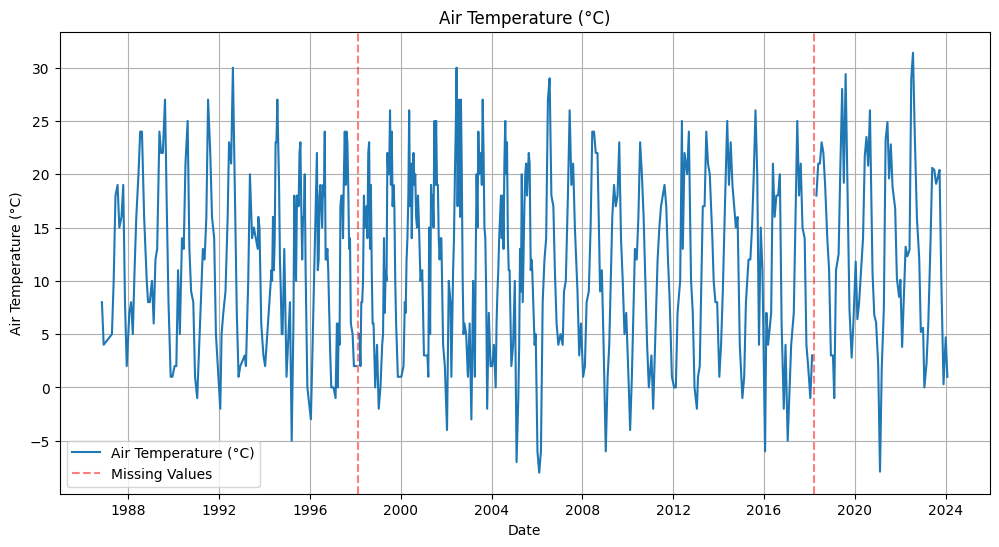

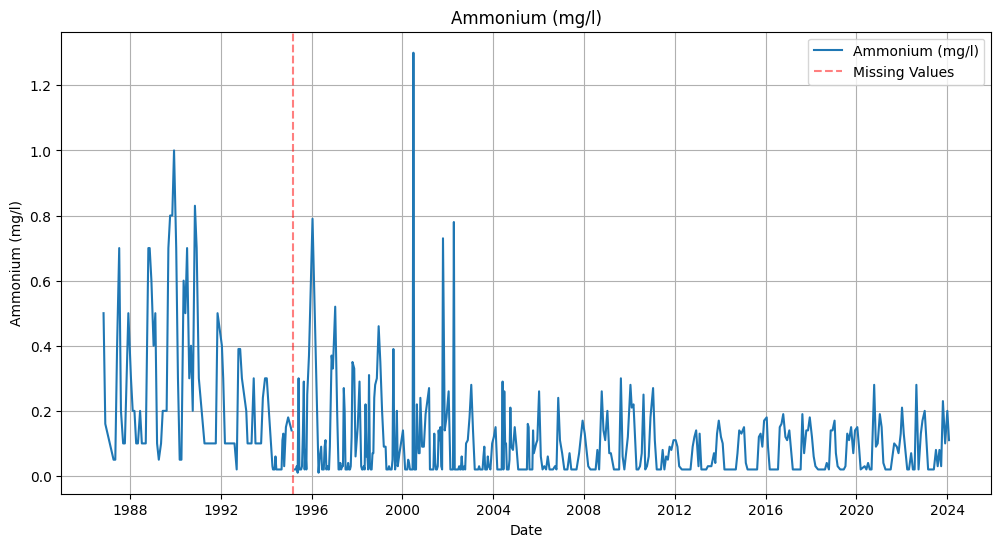

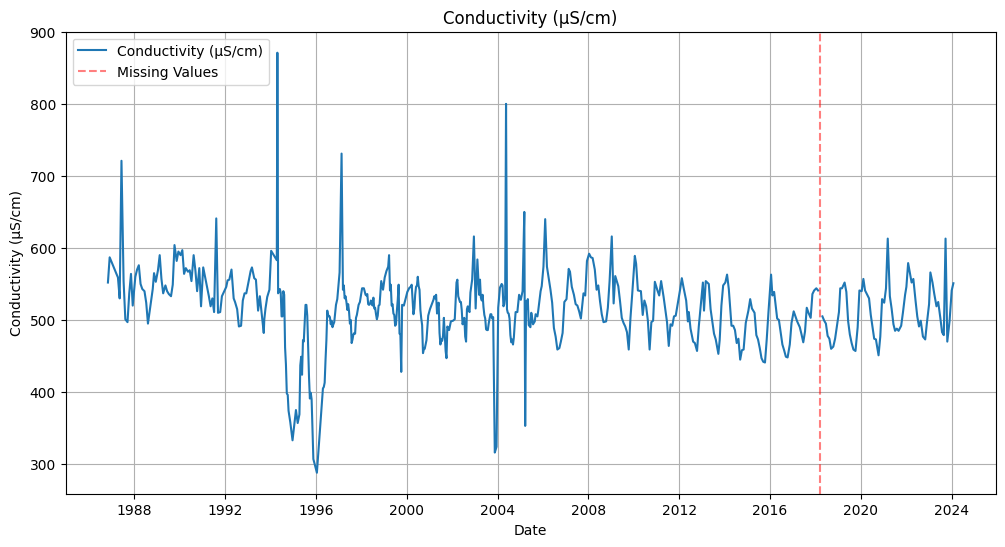

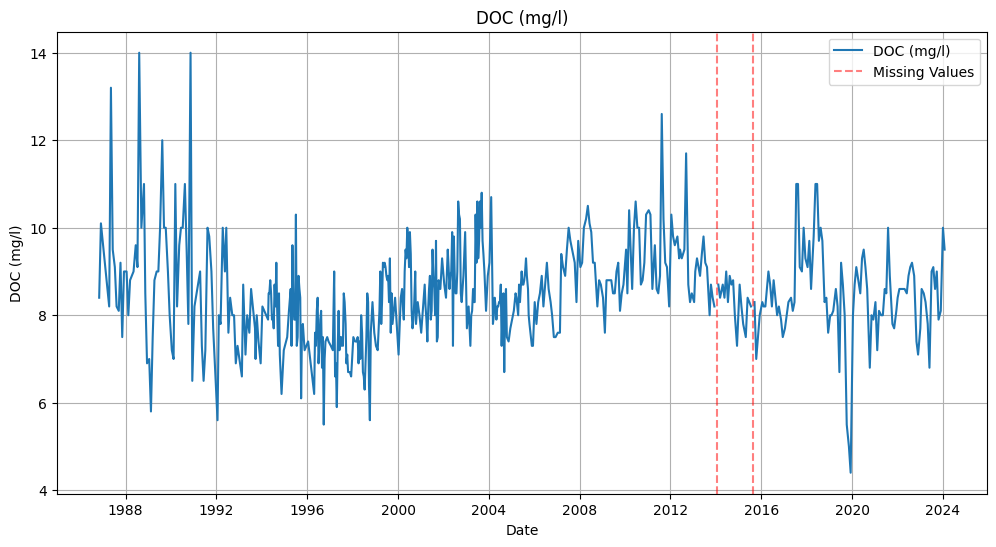

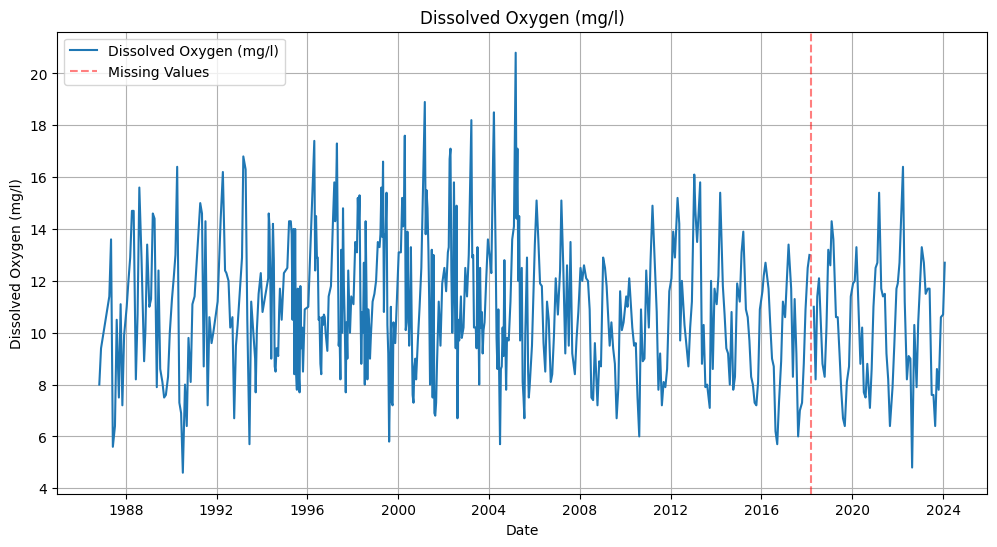

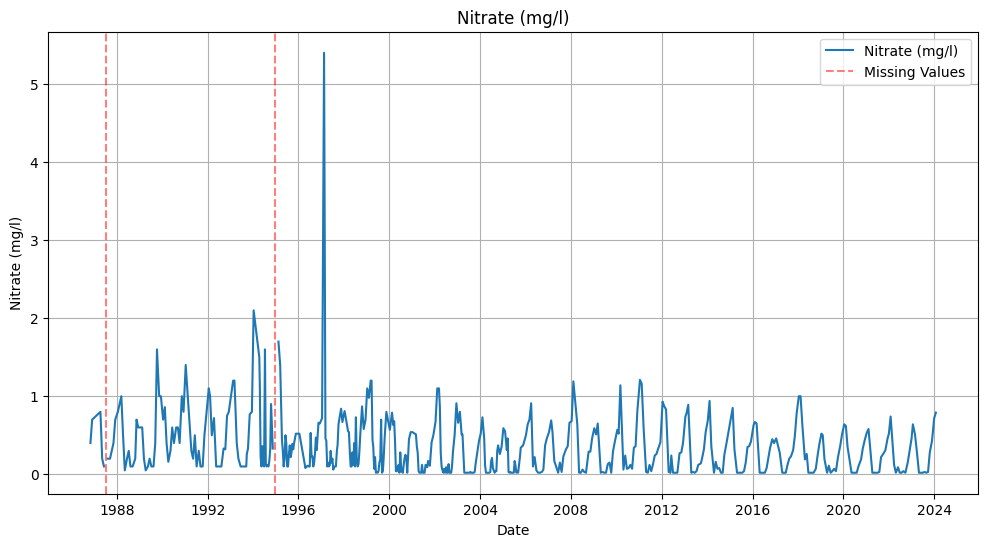

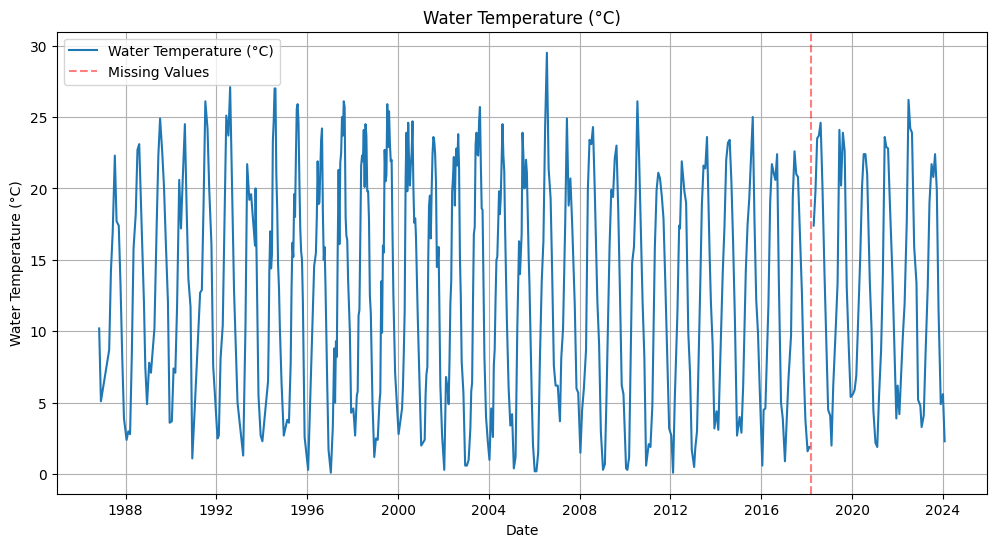

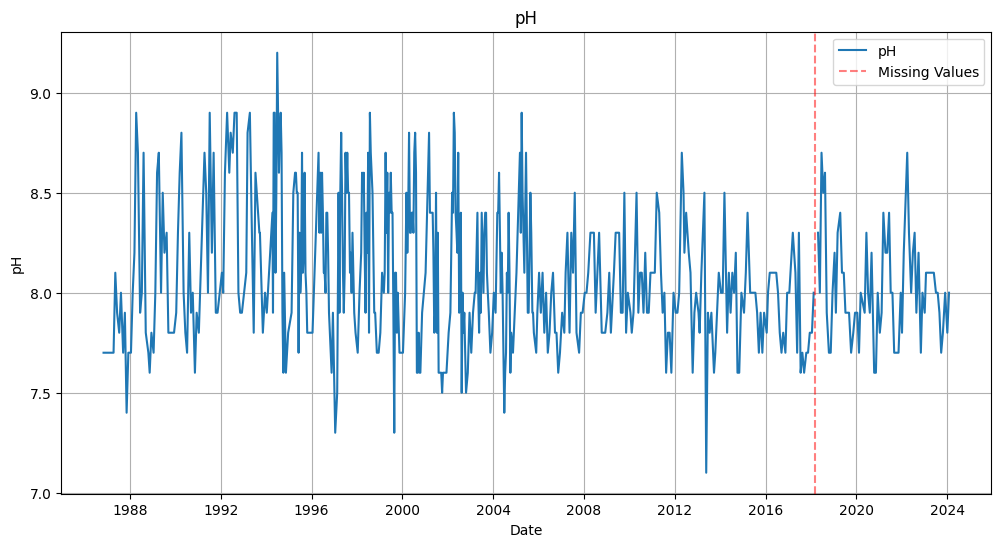

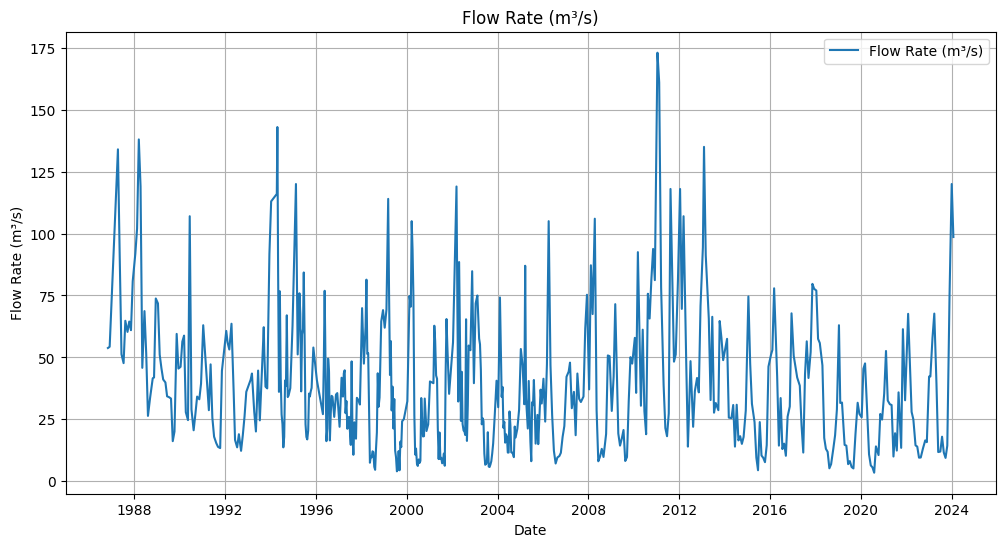

In [332]:
for column in station_df.columns:
    
    df = station_df[column].copy()
    
    plt.figure(figsize=(12, 6))
    
    # Plot the time series
    plt.plot(station_df.index, station_df[column], label=column)
    
    # Add a vertical line for each date with missing values
    missing_dates = station_df[station_df[column].isna()].index
    for date in missing_dates:
        plt.axvline(date, color="red", linestyle="--", alpha=0.5)
        
    # add legend for missing values line if there are any
    if len(missing_dates) > 0:
        plt.plot([], color="red", linestyle="--", alpha=0.5, label="Missing Values")
        
    # Add a title
    plt.title(column)
    
    plt.grid(True)
    
    # Add a legend
    plt.legend()
    
    plt.ylabel(column)
    plt.xlabel("Date")
    
    plt.show()

From the graphs we see that the data is quite clean. For the outliers' removal process we are going to be more conservative as water quality data has strong seasonal effects and could be noisy.

We are going to use [Prophet](https://facebook.github.io/prophet/) to detect outliers. What we are going to do is:
- compute the residuals of the Prophet predictions:
$$
r(t) = y(t) - \hat{y}(t)
$$

- define an anomaly if:
$$
|r(t)| > f * (\hat{y}_{hb}(t) - \hat{y}_{lb}(t))
$$

where *f* is an anomaly factor that can be tuned based on your choice. An outlier is identified as such if the residual of its prediction is greater than *f* times the difference between the upper and lower prediction bounds provided by Prophet, indicating that the actual value significantly deviates from the expected range.

In [333]:
# import the necessary libraries
from prophet import Prophet

16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing


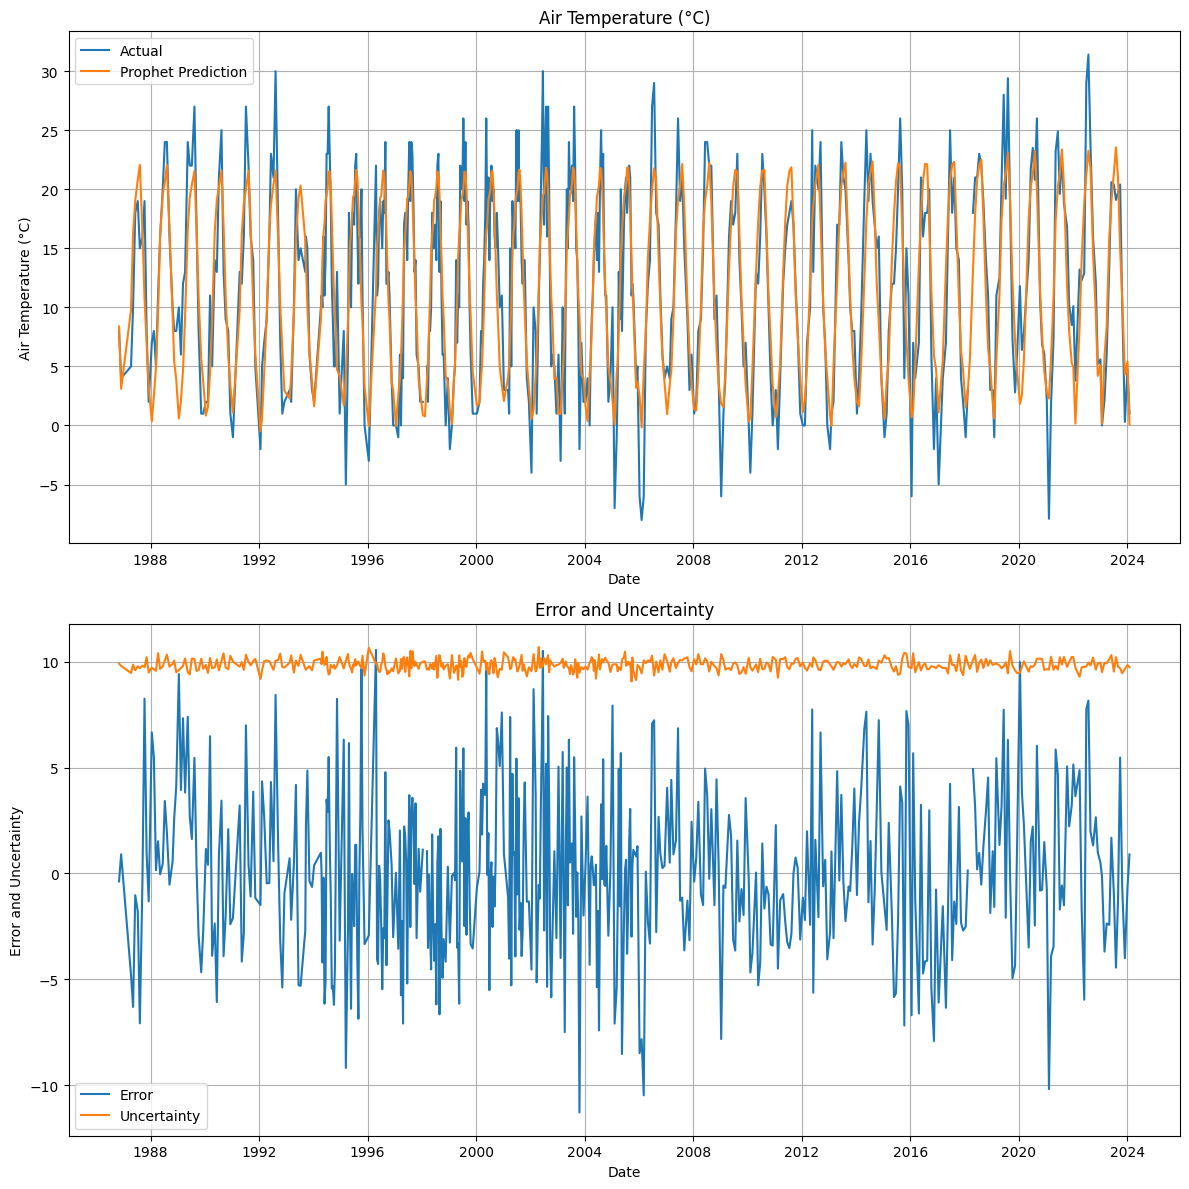

16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing


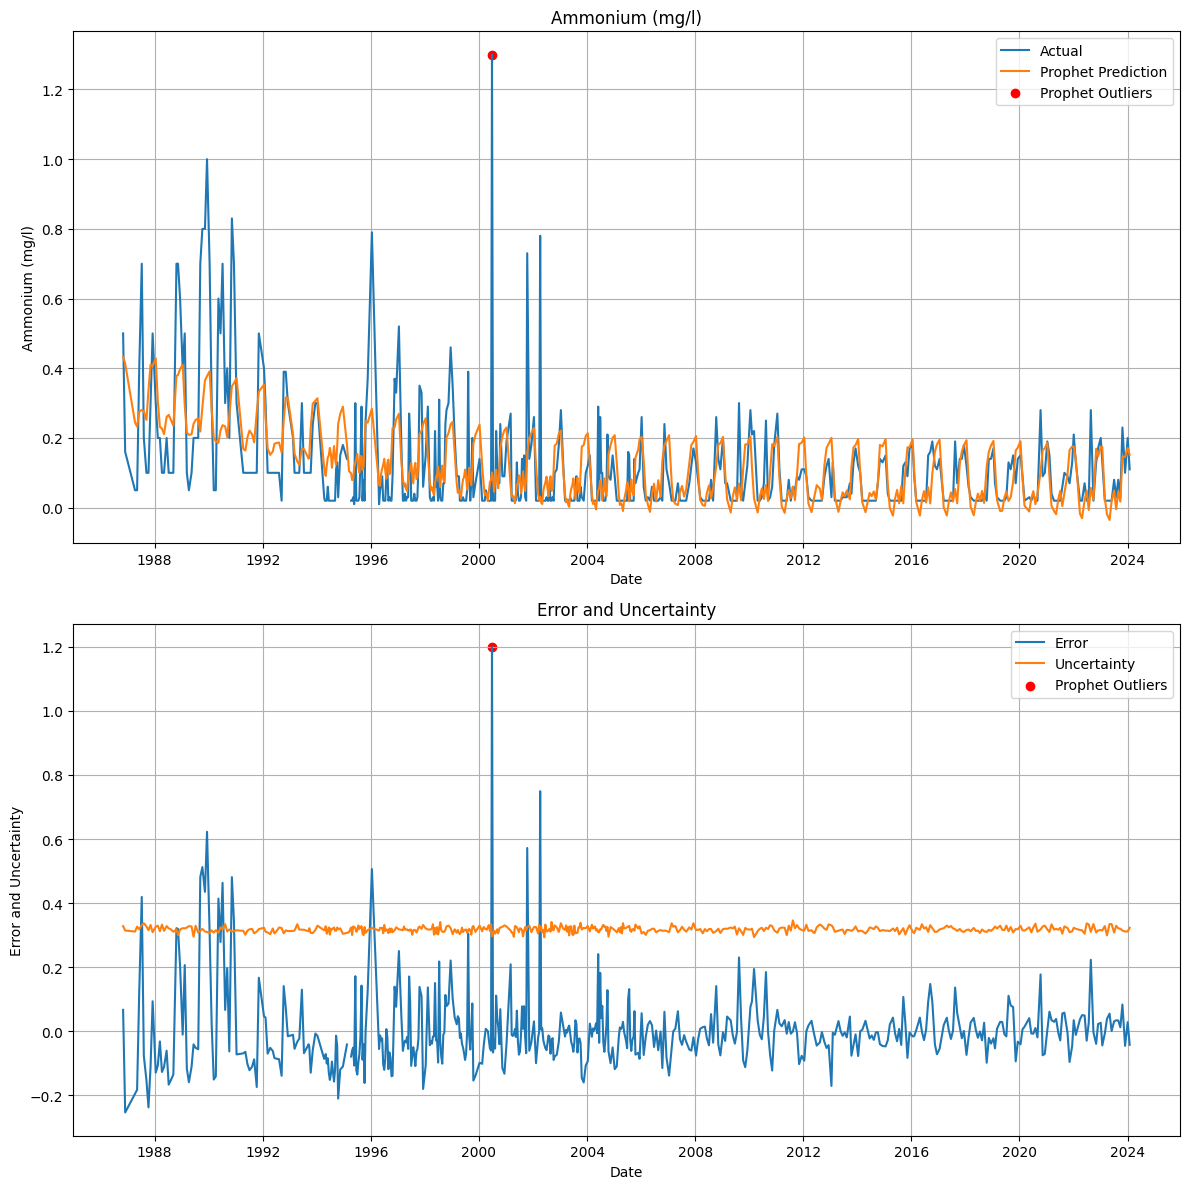

16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing


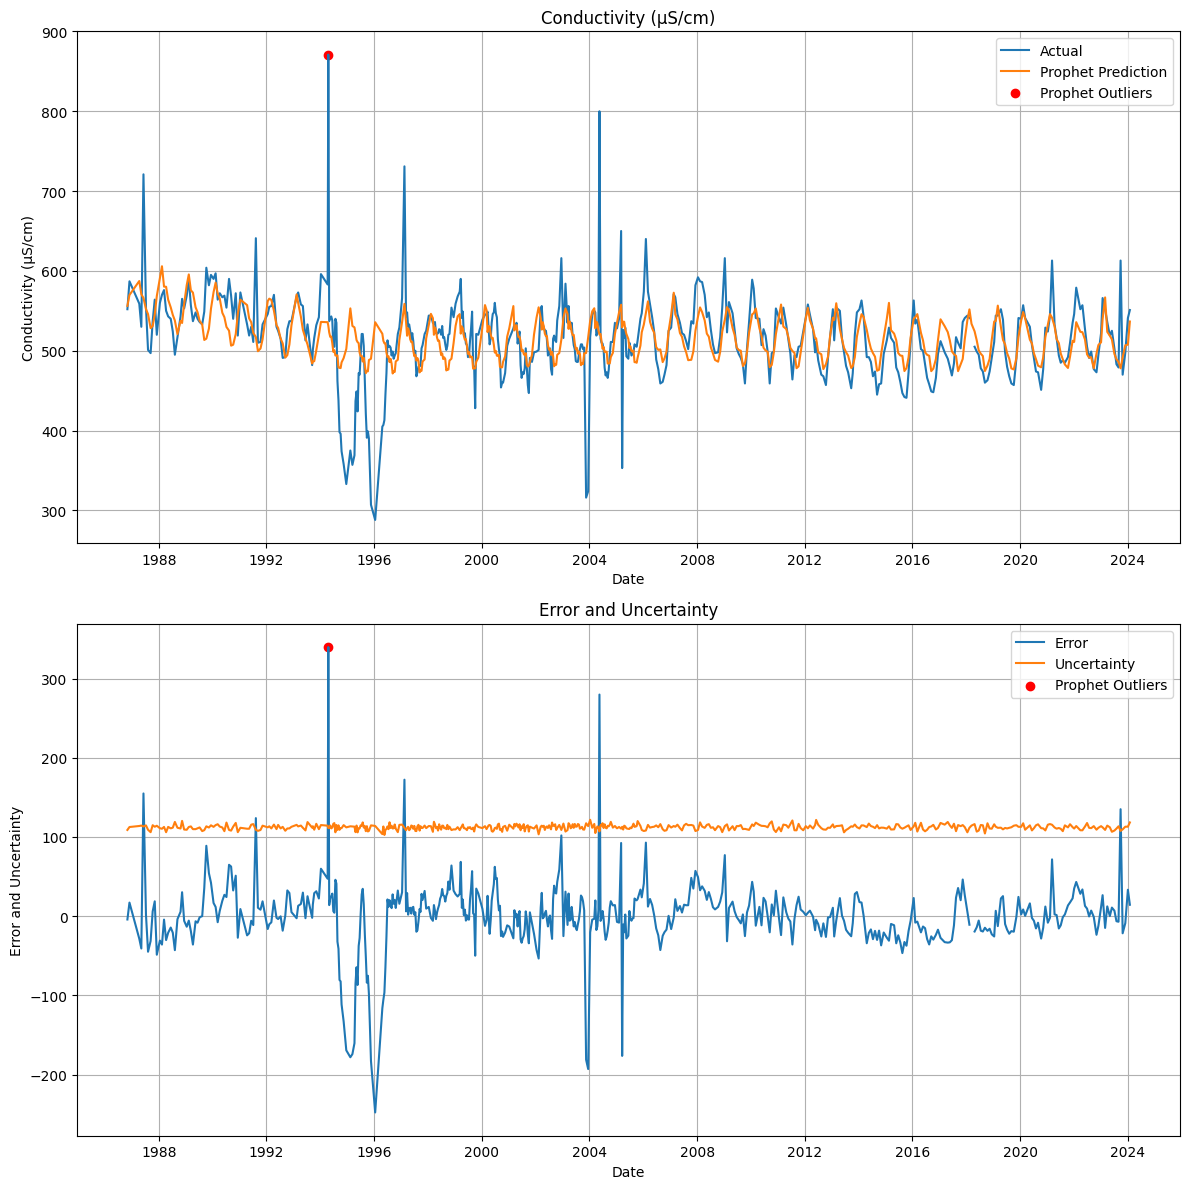

16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing


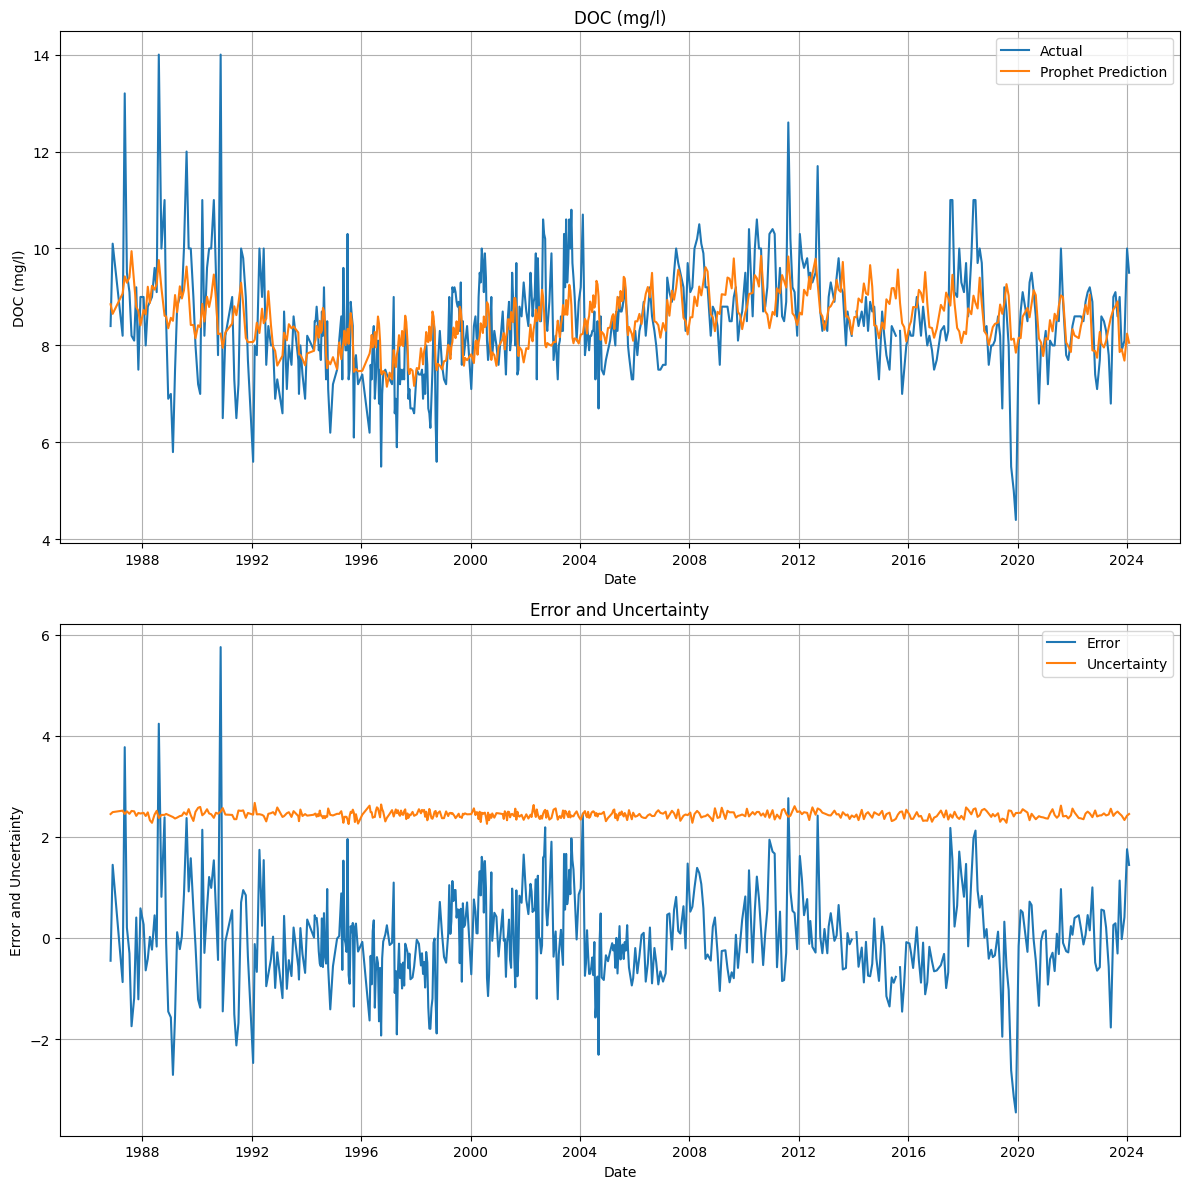

16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing


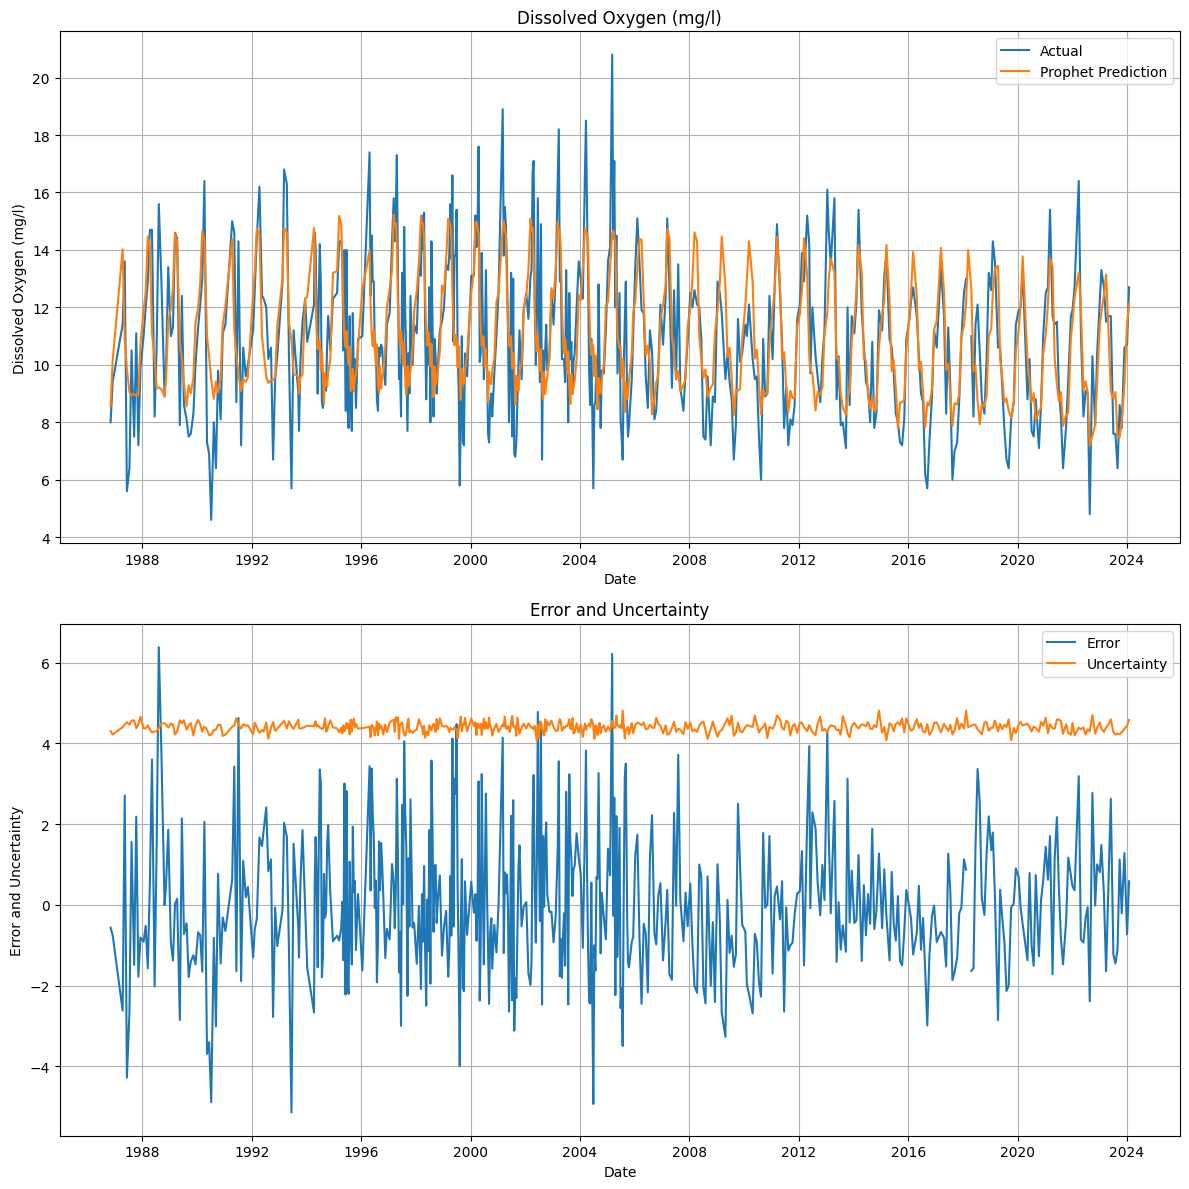

16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing


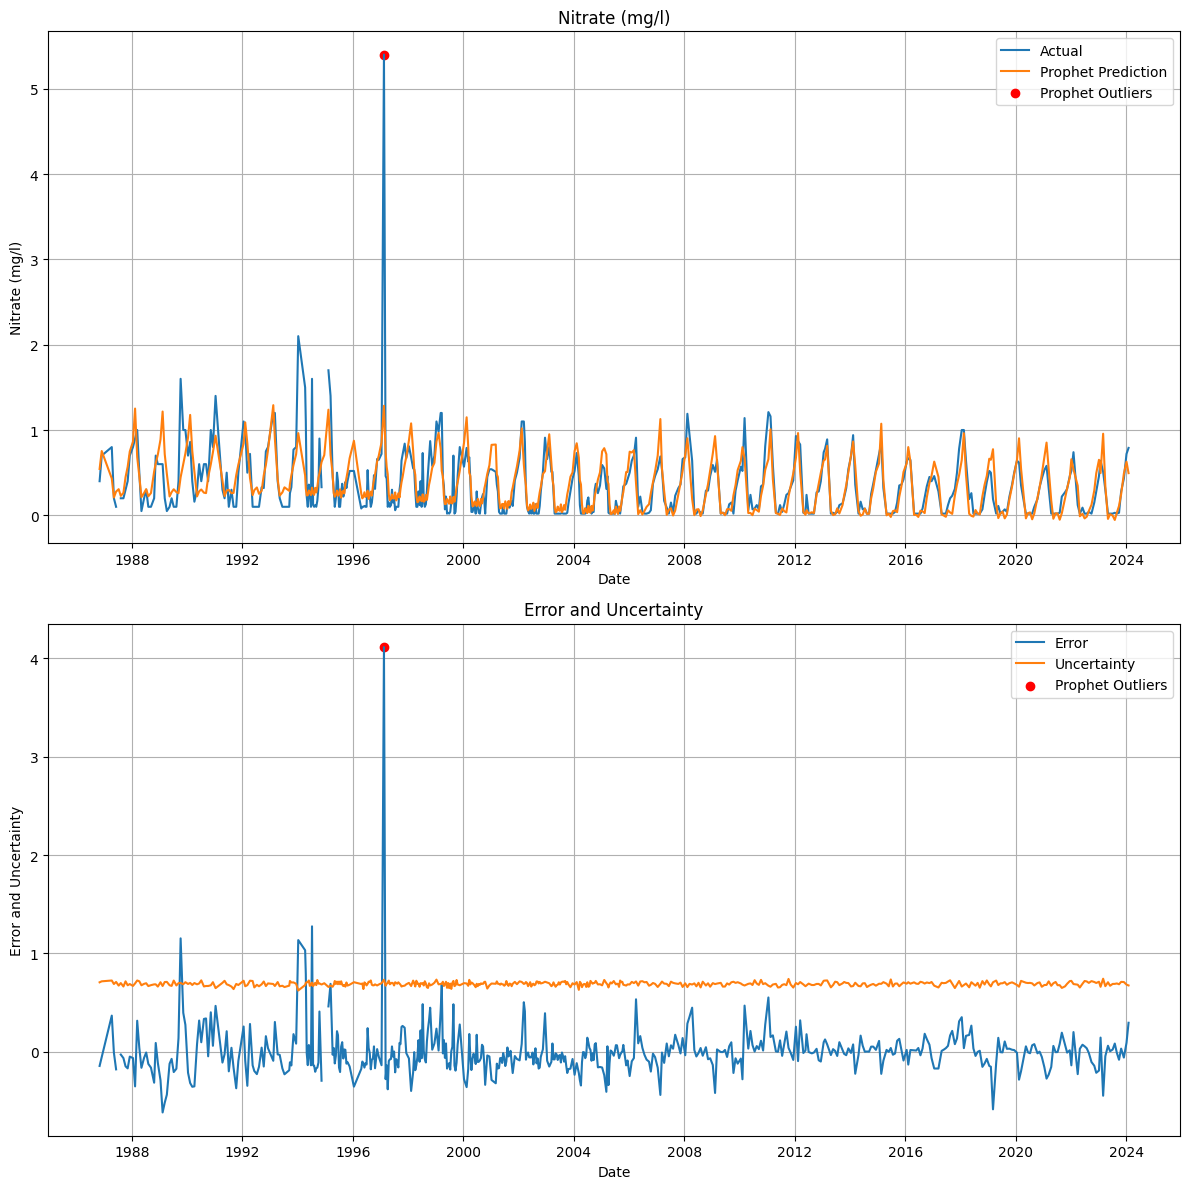

16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing


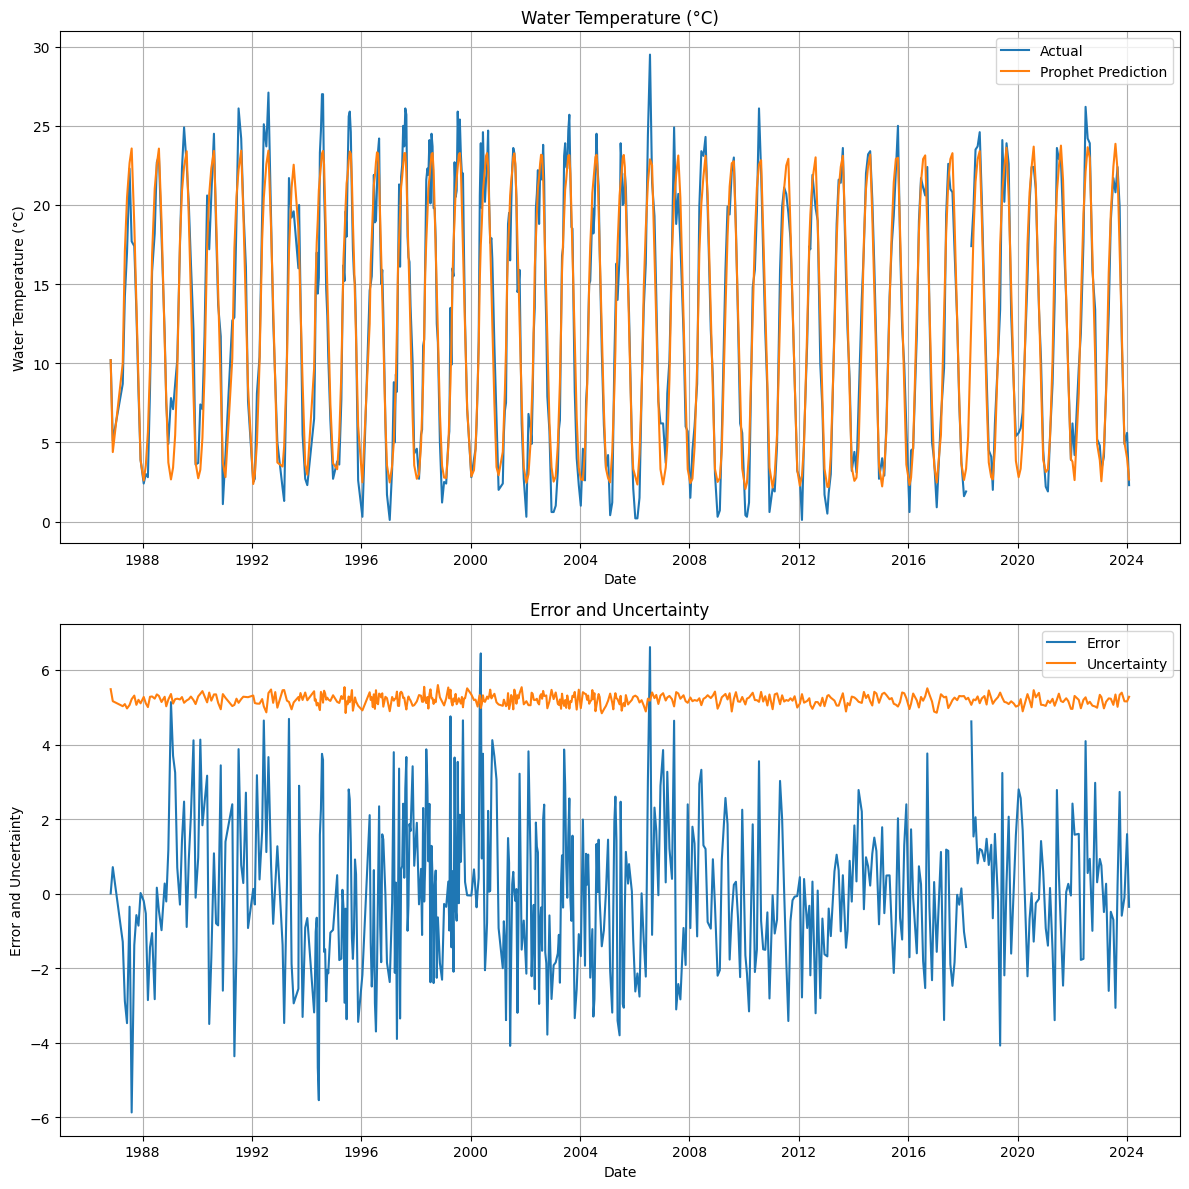

16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing


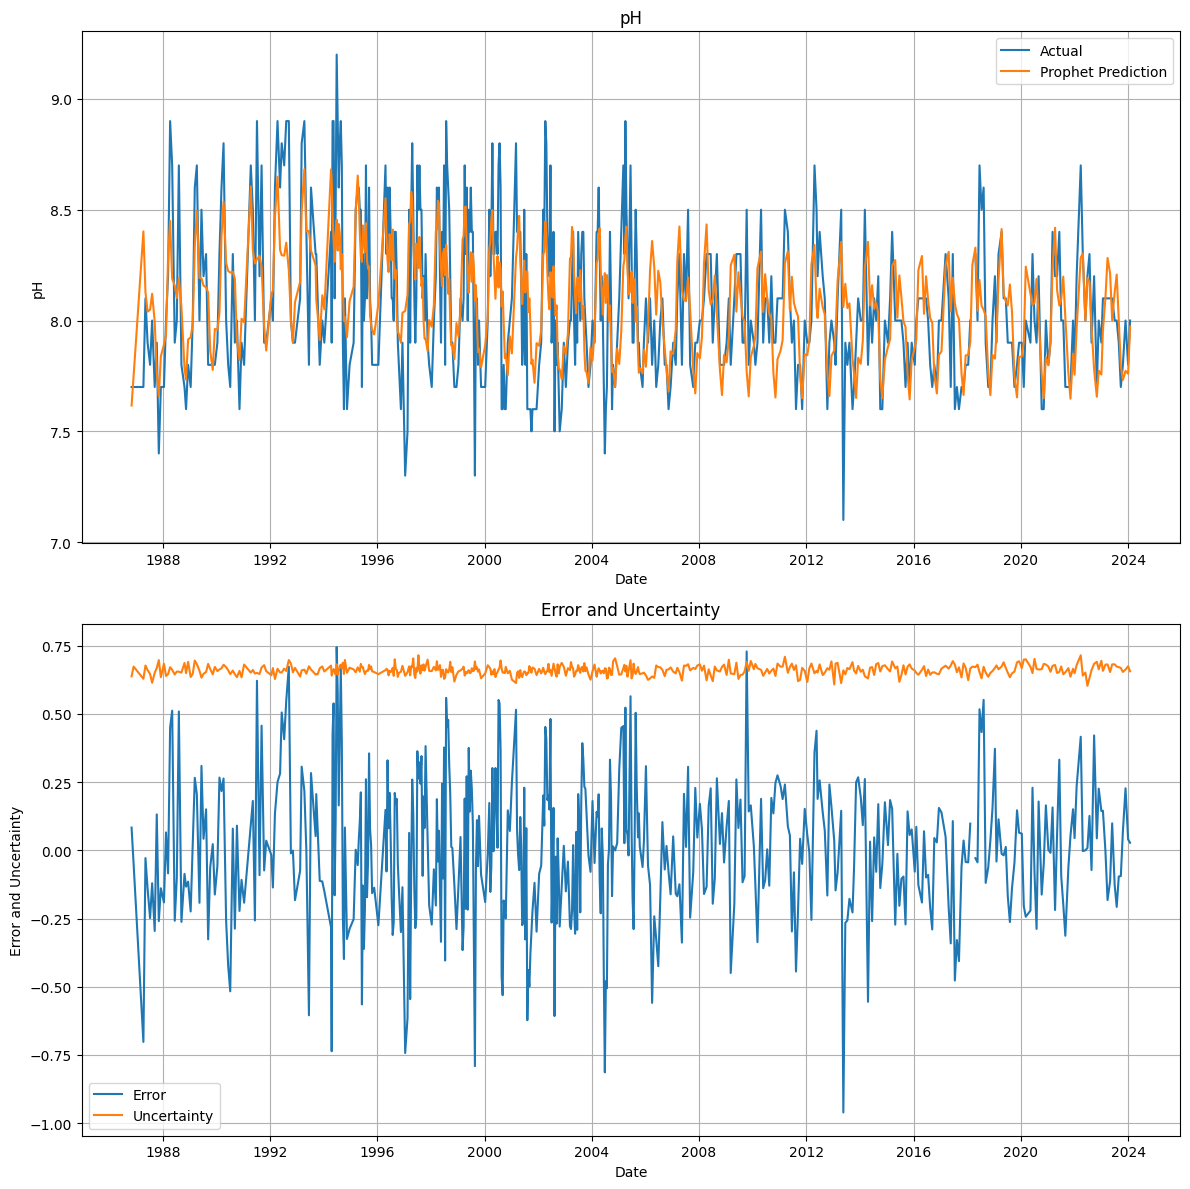

16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing


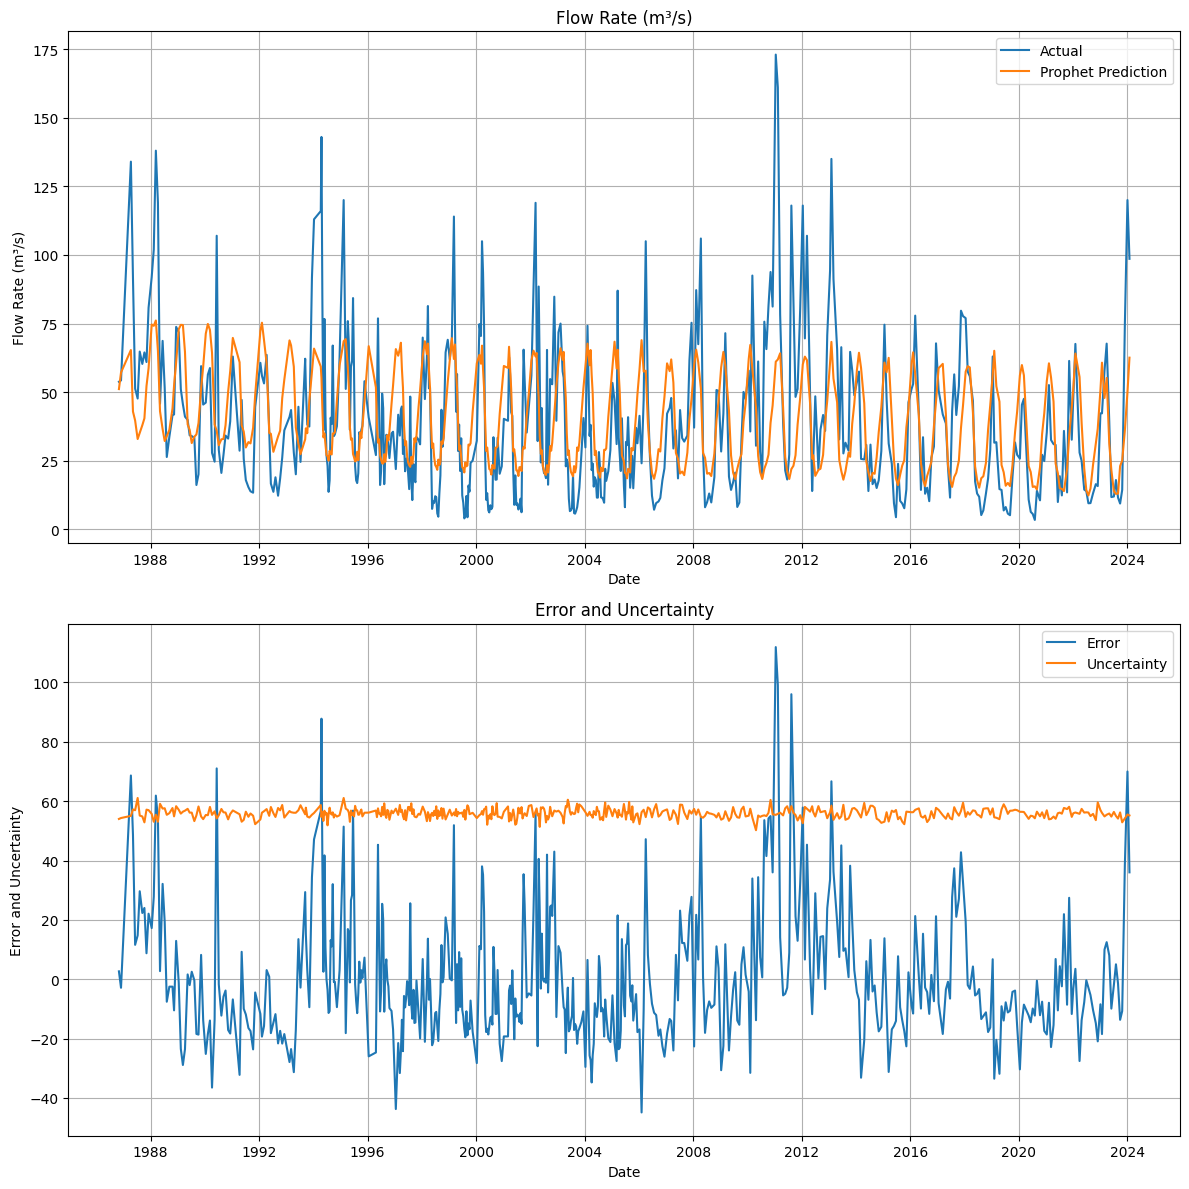

In [334]:
factor = 3 # to be more conservative, usually 1.5 to 3

for column in station_df.columns:
    df = station_df[column].copy()
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    # ===== Prophet =====

    df.index.name = "ds"

    df = df.reset_index()

    df.rename(columns={column: "y"}, inplace=True)

    # using prophet
    model = Prophet()
    model.fit(df)
    
    # We don't want to predict anything, just get the forecast for the training data
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    # Merging forecasted data with original data
    forecasting_final = pd.merge(
        forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]],
        df,
        how="inner",
        on="ds",
    )

    # Calculate the prediction error (residual) and uncertainty
    forecasting_final["error"] = (
        forecasting_final["y"] - forecasting_final["yhat"]
    )
    forecasting_final["uncertainty"] = (
        forecasting_final["yhat_upper"]
        - forecasting_final["yhat_lower"]
    )

    # Anomaly detection
    
    # We are going to consider an anomaly if the error is greater than factor * uncertainty
    forecasting_final["anomaly"] = forecasting_final.apply(
        lambda x: "Yes"
        if (np.abs(x["error"]) > factor * x["uncertainty"])
        else "No",
        axis=1,
    )

    anomaly = forecasting_final[forecasting_final["anomaly"] == "Yes"]
    
    axs[0].plot(forecasting_final["ds"], forecasting_final["y"], label="Actual")
    axs[0].plot(forecasting_final["ds"], forecasting_final["yhat"], label="Prophet Prediction")
    
    if not anomaly.empty:
        axs[0].scatter(anomaly["ds"], anomaly["y"], label="Prophet Outliers", color="red")
    
    axs[1].plot(forecasting_final["ds"], forecasting_final["error"], label="Error")
    axs[1].plot(forecasting_final["ds"], forecasting_final["uncertainty"], label="Uncertainty")
    
    if not anomaly.empty:
        axs[1].scatter(anomaly["ds"], anomaly["error"], label="Prophet Outliers", color="red")

    
    axs[0].set_title(column)
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel(column)
    axs[0].legend()
    axs[0].grid()
    
    axs[1].set_title("Error and Uncertainty")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Error and Uncertainty")
    axs[1].legend()
    axs[1].grid()
    
    plt.tight_layout()
    plt.show()

As we can see, just two points have been labeled as anomalies. We are going to remove them.

In [335]:
# columns to be processed

for column in station_df.columns:
    df = station_df[column].copy()

    df.index.name = "ds"

    df = df.reset_index()

    df.rename(columns={column: "y"}, inplace=True)

    # using prophet
    model = Prophet()
    model.fit(df)
    
    # Make predictions for both columns
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    # Merging forecasted data with the original data
    forecasting_final = pd.merge(
        forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]],
        df,
        how="inner",
        on="ds",
    )

    # Calculate the prediction error and uncertainty
    forecasting_final["error"] = (
        forecasting_final["y"] - forecasting_final["yhat"]
    )
    forecasting_final["uncertainty"] = (
        forecasting_final["yhat_upper"]
        - forecasting_final["yhat_lower"]
    )

    # Anomaly detection
    forecasting_final["anomaly"] = forecasting_final.apply(
        lambda x: "Yes"
        if (np.abs(x["error"]) > factor * x["uncertainty"])
        else "No",
        axis=1,
    )

    # remove the outliers by replacing them with NaN
    forecasting_final.loc[
        forecasting_final["anomaly"] == "Yes", "y"
    ] = np.nan

    df = forecasting_final[["ds", "y"]]

    df.set_index("ds", inplace=True)

    df = df.rename(columns={"y": column})

    station_df.loc[df.index, column] = df[column]


16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1] done processing
16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1]

To make the analysis easier, we are going to resample the data to a monthly frequency
and calculate the mean value for each month if there are multiple samples in the same month.

Also, the resampling will ease the missing values imputation as we will have a regular time series.

In [336]:
station_df = station_df.resample("ME").mean()

# We are going to impute the missing values using the interpolation method for the time series
# This method will fill the missing values by interpolating between the two closest non missing values
station_df = station_df.interpolate(method="time")

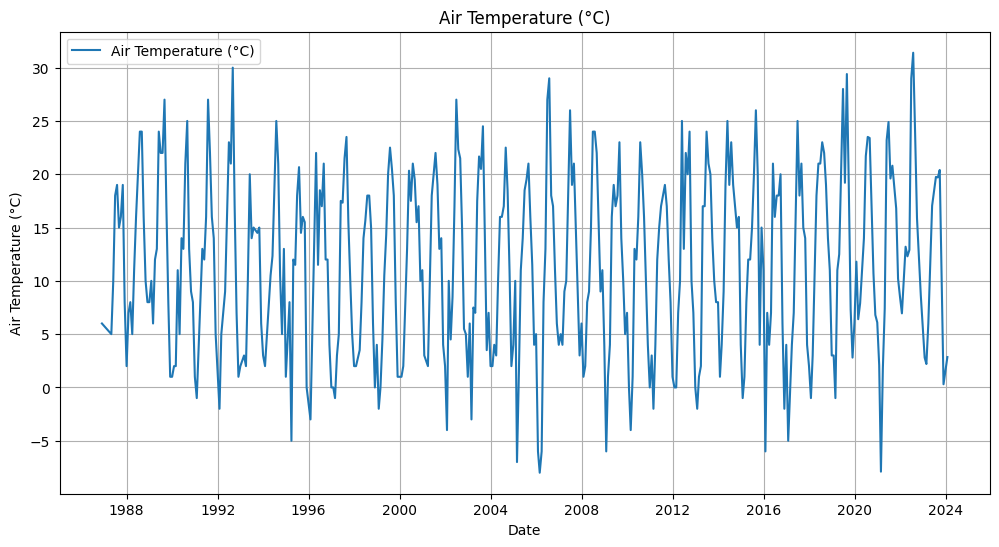

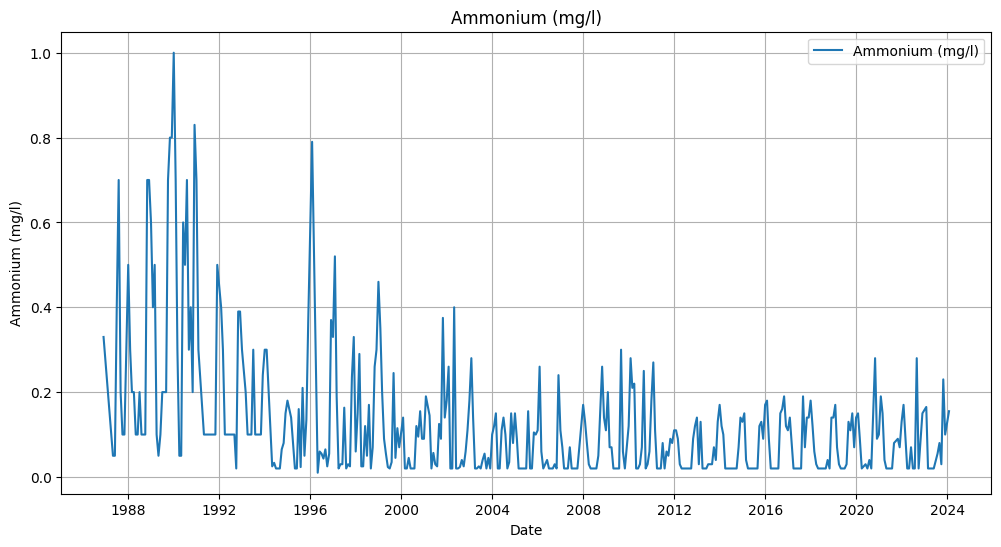

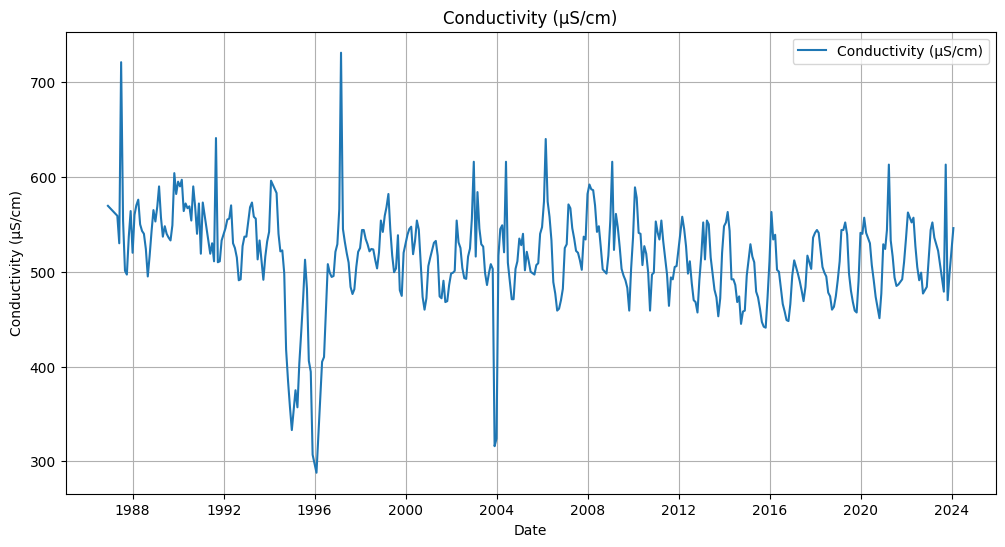

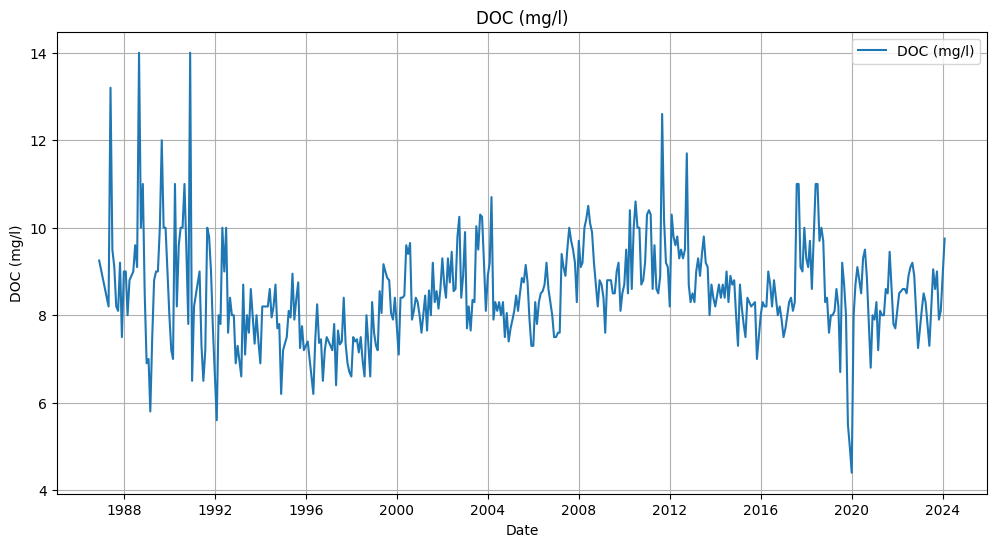

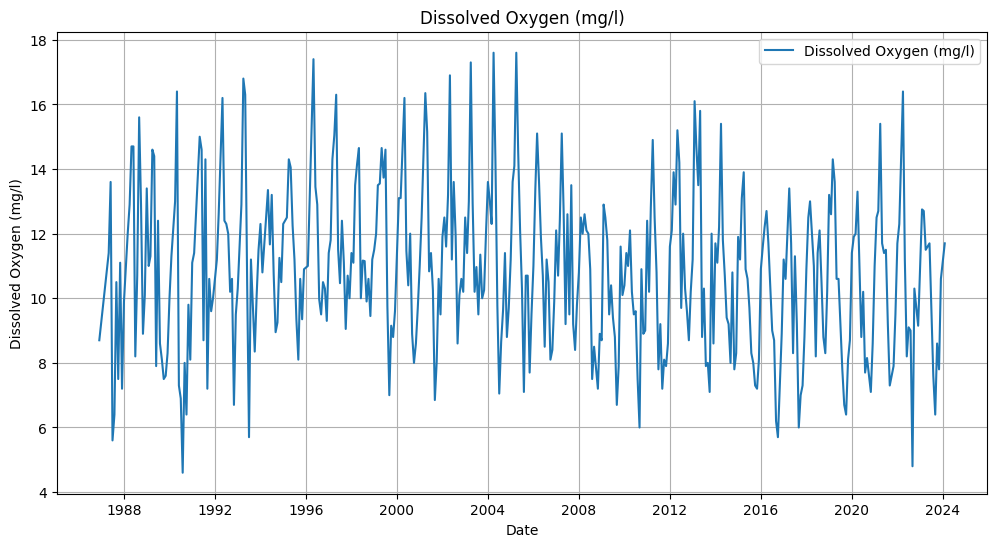

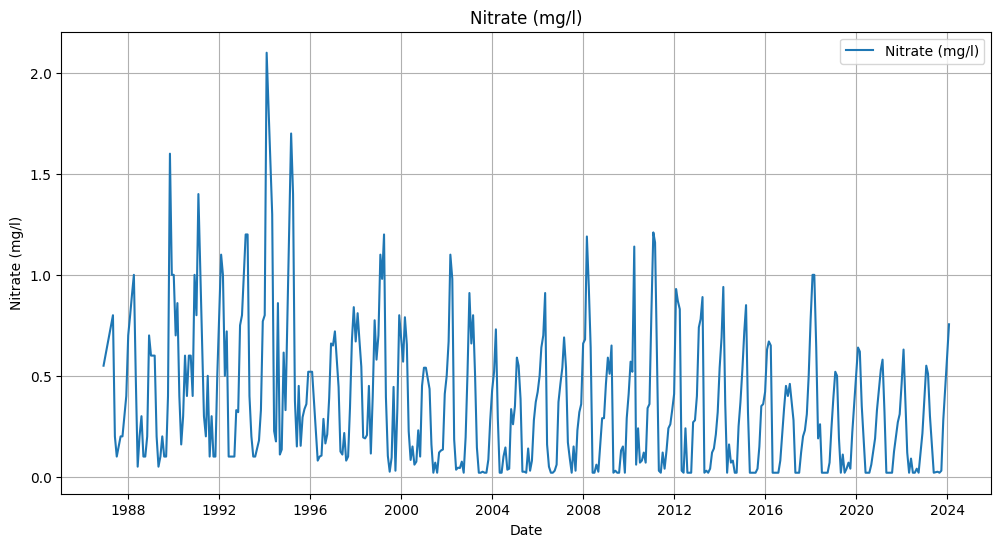

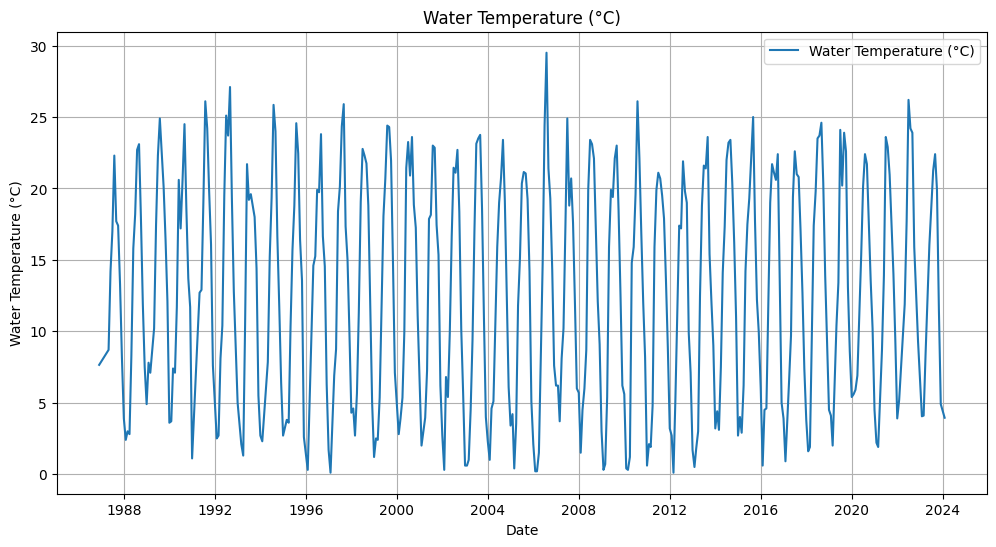

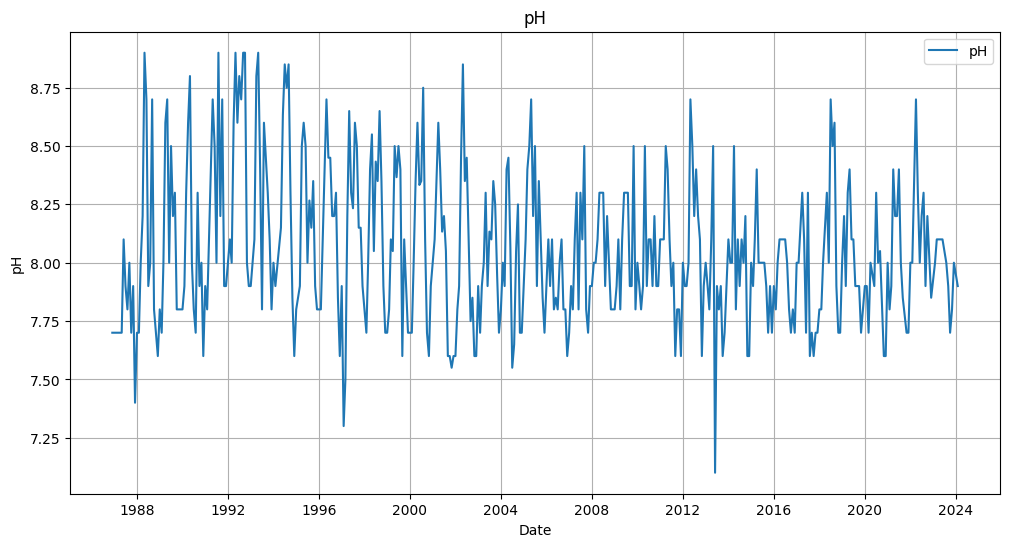

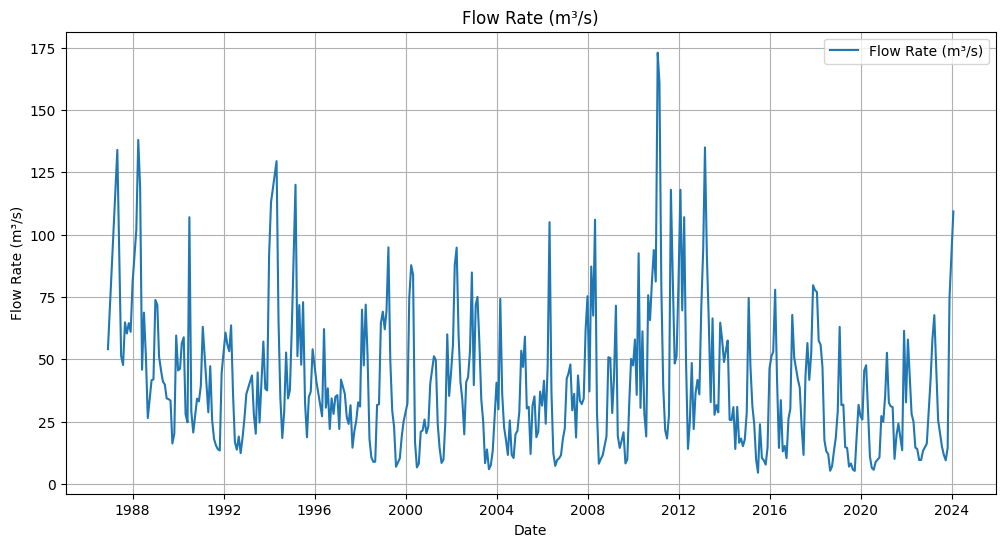

In [337]:
# Show the plots of preprocessed data, with missing values filled
for column in station_df.columns:
    
    df = station_df[column].copy()
    
    plt.figure(figsize=(12, 6))
    
    # Plot the time series
    plt.plot(station_df.index, station_df[column], label=column)
    
    # Add a vertical line for each date with missing values
    missing_dates = station_df[station_df[column].isna()].index
    for date in missing_dates:
        plt.axvline(date, color="red", linestyle="--", alpha=0.5)
        
    # add legend for missing values line if there are any
    if len(missing_dates) > 0:
        plt.plot([], color="red", linestyle="--", alpha=0.5, label="Missing Values")
        
    # Add a title
    plt.title(column)
    
    plt.grid(True)
    
    # Add a legend
    plt.legend()
    
    plt.ylabel(column)
    plt.xlabel("Date")
    
    plt.show()

In [338]:
# Let's have a final description of the data
station_df.describe()

Air Temperature (°C)  Ammonium (mg/l)  ...          pH  Flow Rate (m³/s)
count            447.000000       447.000000  ...  447.000000        447.000000
mean              11.260376         0.128686  ...    8.052999         41.249226
std                8.178845         0.153153  ...    0.317834         28.219899
min               -8.000000         0.010000  ...    7.100000          4.460000
25%                4.000000         0.020000  ...    7.800000         20.100000
50%               11.000000         0.090000  ...    8.000000         34.300000
75%               18.000000         0.155000  ...    8.283333         53.800000
max               31.400000         1.000000  ...    8.900000        173.000000

[8 rows x 9 columns]

## Meteorological Data

As a final step to build the final dataset, we need to add the precipitation measurements available from an airport quite distant from the station. In order to assess similarity between the two sampling points, we have to evaluate the similarity of the measurements of common variables. The only variable in common between the two DataFrames is the Air Temperature.

In [339]:
# load the data
meteo_df = pd.read_csv(
    os.path.join(
        data_path, "produkt_klima_tag_19480101_20231231_00433.csv",
    ),
    sep=";",
)

In [340]:
meteo_df.rename(
    columns={
        "STATIONS_ID": "Station ID",
        "MESS_DATUM": "DateTime",
        "  FX": "Wind Speed Max (m/s)",
        "  FM": "Wind Speed Mean (m/s)",
        " RSK": "Cumulated Rainfall (mm)",
        "RSKF": "Cumulated Rainfall Type",
        " SDK": "Sunshine Duration (hours)",
        "SHK_TAG": "Snow Height (cm)",
        "  NM": "Cloud Coverage (1/8)",
        " VPM": "Vapor Pressure (hPa)",
        "  PM": "Pressure (hPa)",
        " TMK": "Temperature Mean (°C)",
        " UPM": "Humidity (%)",
        " TXK": "Temperature Max at 2m (°C)",
        " TNK": "Temperature Min at 2m (°C)",
        " TGK": "Temperature Min at 5cm (°C)",
    },
    inplace=True,
)

meteo_df["DateTime"] = pd.to_datetime(meteo_df["DateTime"], format="%Y%m%d")
meteo_df.set_index("DateTime", inplace=True)

In [341]:
# Just take the necessary columns
meteo_df = meteo_df[
    [
        "Temperature Mean (°C)",
        "Cumulated Rainfall (mm)",
    ]
]

In [342]:
# Inspect the DataFrame
info_meteo_df = pd.DataFrame(
    index=pd.Index(
        [
            "N Samples",
            "% Missing Values",
            "Frequency (days)",
            "Mean",
            "Std",
            "Start Date",
            "End Date",
        ],
        name="Info",
    ),
    columns=meteo_df.columns,
)

In [343]:
for column in meteo_df.columns:
    start_date = meteo_df[column].dropna().index.min()
    
    end_date = meteo_df[column].dropna().index.max()

    df = meteo_df[start_date:end_date][column]

    print(f"Start date for {column}: {start_date}")
    print(f"End date for {column}: {end_date}")

    missing_values = df.isna().sum() / df.shape[0]
    print(f"Missing values for {column}: {missing_values}")

    frequency = df.index.to_series().diff().value_counts().index[0].days
    print(f"Frequency for {column}: {frequency}")

    info_meteo_df.loc["N Samples", column] = (
        meteo_df[column].dropna().shape[0]
    )
    info_meteo_df.loc["% Missing Values", column] = missing_values
    info_meteo_df.loc["Frequency (days)", column] = frequency
    
    info_meteo_df.loc["Mean", column] = df.mean()
    info_meteo_df.loc["Std", column] = df.std()
    
    info_meteo_df.loc["Start Date", column] = start_date.strftime("%Y-%m-%d")
    info_meteo_df.loc["End Date", column] = end_date.strftime("%Y-%m-%d")

Start date for Temperature Mean (°C): 1948-01-01 00:00:00
End date for Temperature Mean (°C): 2023-12-31 00:00:00
Missing values for Temperature Mean (°C): 0.0
Frequency for Temperature Mean (°C): 1
Start date for Cumulated Rainfall (mm): 1948-01-01 00:00:00
End date for Cumulated Rainfall (mm): 2023-12-31 00:00:00
Missing values for Cumulated Rainfall (mm): 0.0
Frequency for Cumulated Rainfall (mm): 1


In [344]:
info_meteo_df

Temperature Mean (°C) Cumulated Rainfall (mm)
Info                                                          
N Samples                        27759                   27759
% Missing Values                   0.0                     0.0
Frequency (days)                     1                       1
Mean                          9.916967                0.926784
Std                           7.879064               25.767207
Start Date                  1948-01-01              1948-01-01
End Date                    2023-12-31              2023-12-31

We can see that there are not missing values in the time series. The time range is very long, from 1948 to 2023. The sampling frequency is daily, so we need to adjust it to monthly.

However, the standard deviation of the Cumulated Rainfall is a bit high, let's visualize the plots.

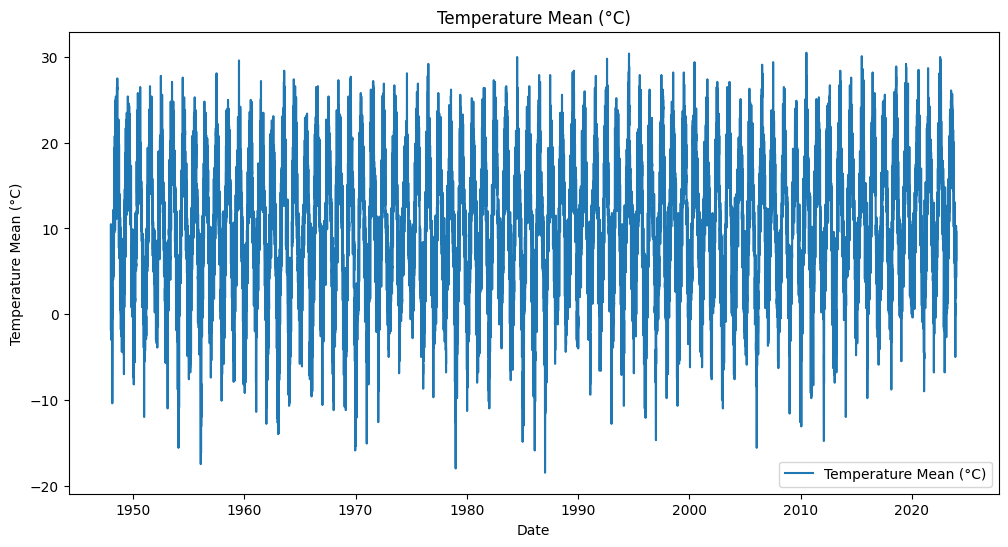

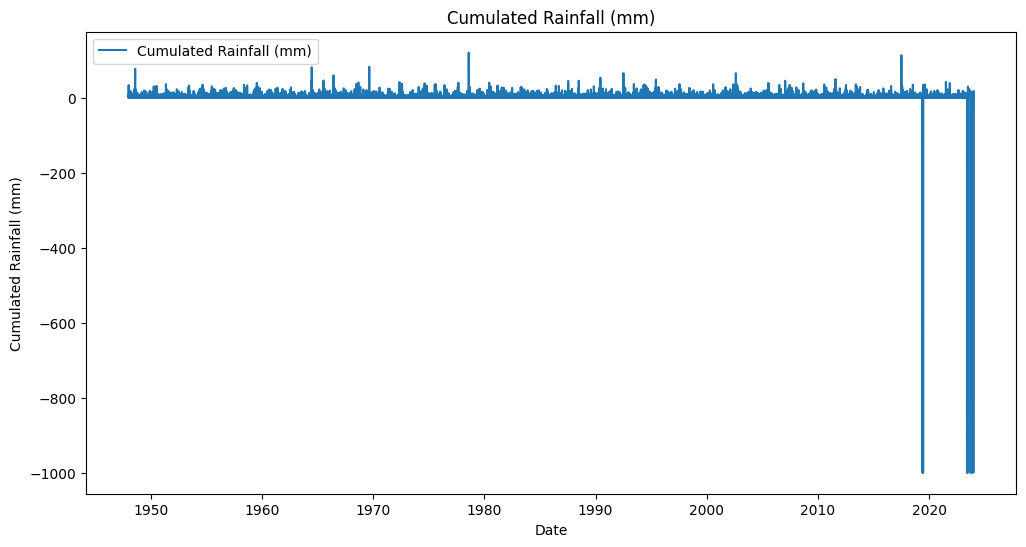

In [345]:
# Visually inspect the data

for column in meteo_df.columns:
    fig = plt.figure(figsize=(12, 6))

    plt.plot(meteo_df.index, meteo_df[column], label=column)

    plt.title(column)
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()

    plt.show()

The cumulated rainfall has some errors in the measurements, let's delete the measurements that are < 0.

In [346]:
meteo_df.loc[
    meteo_df["Cumulated Rainfall (mm)"] < 0, ["Cumulated Rainfall (mm)"]
] = np.nan

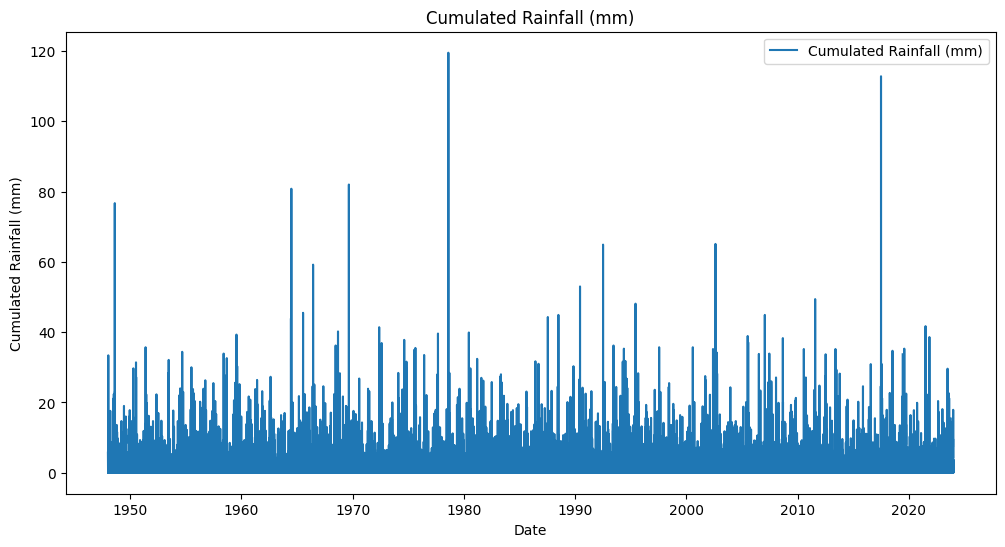

In [347]:
column = "Cumulated Rainfall (mm)"

fig = plt.figure(figsize=(12, 6))

plt.plot(meteo_df.index, meteo_df[column], label=column)

plt.title(column)
plt.xlabel("Date")
plt.ylabel(column)
plt.legend()

plt.show()

The values are now reasonable. Let's resample to monthly measurements and fill the missing values.

In [348]:
# resample the data to monthly
meteo_df = meteo_df.resample("ME").mean()

meteo_df = meteo_df.interpolate(method="time")

We are now going to compare the air temperature measurements of the two sites to understand if they can be considered similar, in order to merge the rainfall measurements in the final dataset. We compute the pearson correlation as a proxy of how much the two time series are correlated. We also show visual evidence as well as a scatter plot.

In [349]:
from scipy.stats import pearsonr

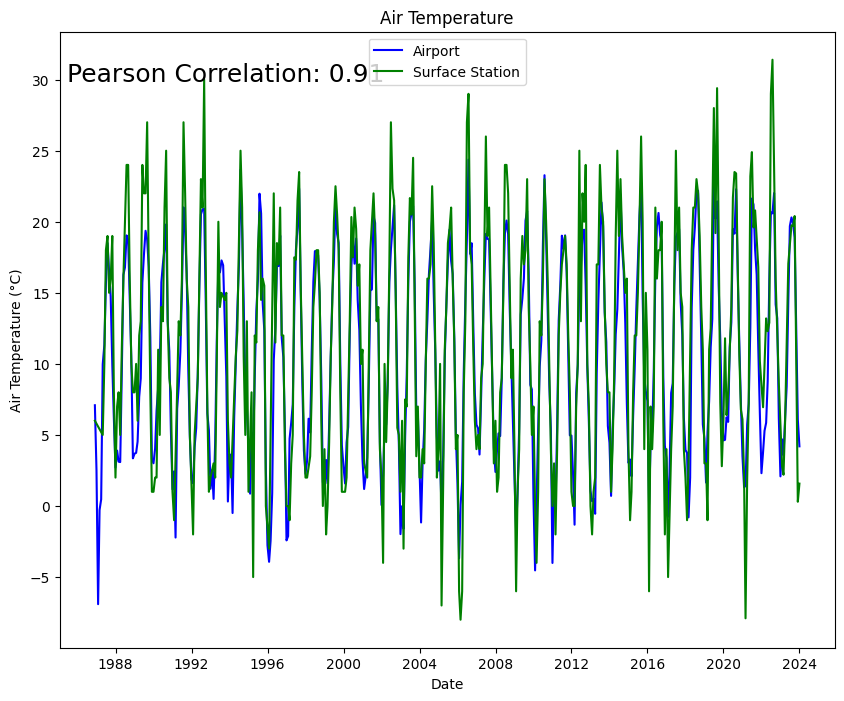

In [350]:
# compute pearson correlation

start_date = station_df.index.min()
end_date = station_df.index.max()

# take the common date range with the airport
start_date = max(start_date, meteo_df.index.min())
end_date = min(end_date, meteo_df.index.max())

airport_df = meteo_df[start_date:end_date].copy()

# take the common date range with the station
df = station_df[
    (station_df.index >= start_date)
    & (station_df.index <= end_date)
].copy()

# compute pearson correlation
corr, _ = pearsonr(
    airport_df["Temperature Mean (°C)"],
    df["Air Temperature (°C)"],
)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot Airport data
ax.plot(airport_df.index, airport_df["Temperature Mean (°C)"], color="blue", label="Airport")

# Plot Station data
ax.plot(df.index, df["Air Temperature (°C)"], color='green', label=f"Surface Station")

# Add the correlation to the plot
ax.text(0.01, 0.95, f"Pearson Correlation: {corr:.2f}", transform=ax.transAxes, fontsize=18, verticalalignment='top')

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Air Temperature (°C)")
ax.legend()
ax.set_title("Air Temperature")

plt.show()

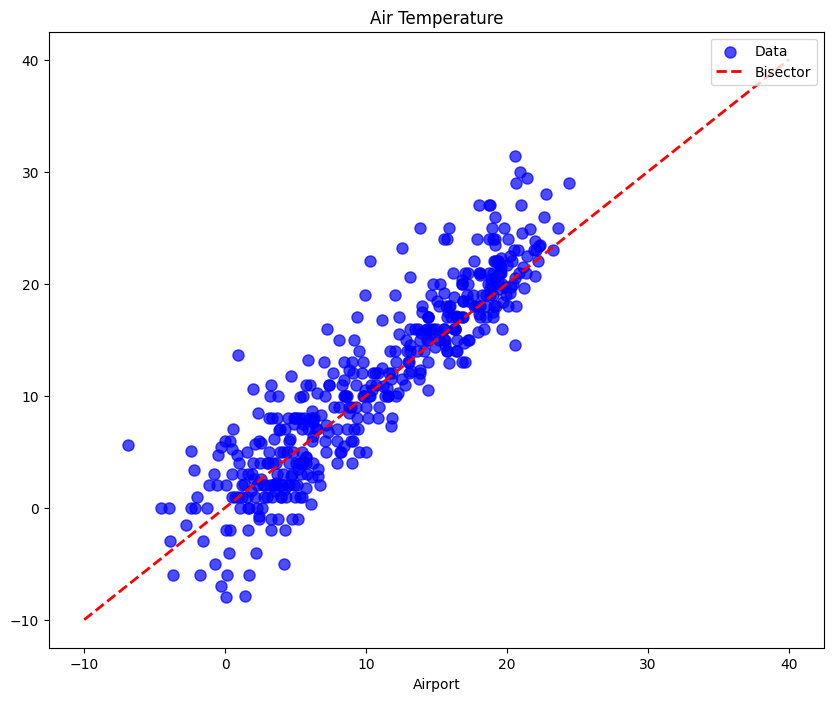

In [351]:
# The only variable in common between the two DataFrames is the Temperature Mean
start_date = station_df.index.min()
end_date = station_df.index.max()

# take the common date range with the airport
start_date = max(start_date, meteo_df.index.min())
end_date = min(end_date, meteo_df.index.max())

airport_df = meteo_df[start_date:end_date].copy()

# take the common date range with the station
df = station_df[
    (station_df.index >= start_date)
    & (station_df.index <= end_date)
].copy()

fig, ax = plt.subplots(figsize=(10, 8))

# Plot Data
ax.scatter(airport_df["Temperature Mean (°C)"], df["Air Temperature (°C)"], 
           s=64, color="blue", alpha=0.7, label="Data")

# Add line on bisector
ax.plot([-10, 40], [-10, 40], color="red", linewidth=2, linestyle="--", label="Bisector")

# Set labels and title
ax.set_xlabel("Airport")
ax.set_title("Air Temperature")
ax.legend(loc="upper right")

plt.show()

We have strong correlation between the two measurements, and visually we can see that the seasonal pattern is very similar. We can establish that they are similar, and we can merge the rainfall into the final dataset.

In [352]:
station_df['Cumulated Rainfall (mm)'] = np.nan

start_date = station_df.index.min()
end_date = station_df.index.max()

# take the common date range with the airport
start_date = max(start_date, meteo_df.index.min())
end_date = min(end_date, meteo_df.index.max())

airport_df = meteo_df[start_date:end_date].copy()

# take the common date range with the station
# Identify the indices in sw_df that match the station_id and are within the date range
station_df.loc[
    (station_df.index >= start_date)
    & (station_df.index <= end_date),
    "Cumulated Rainfall (mm)",
] = airport_df["Cumulated Rainfall (mm)"]

# interpolate the missing value of the Cumulated Rainfall
station_df["Cumulated Rainfall (mm)"] = station_df["Cumulated Rainfall (mm)"].interpolate()

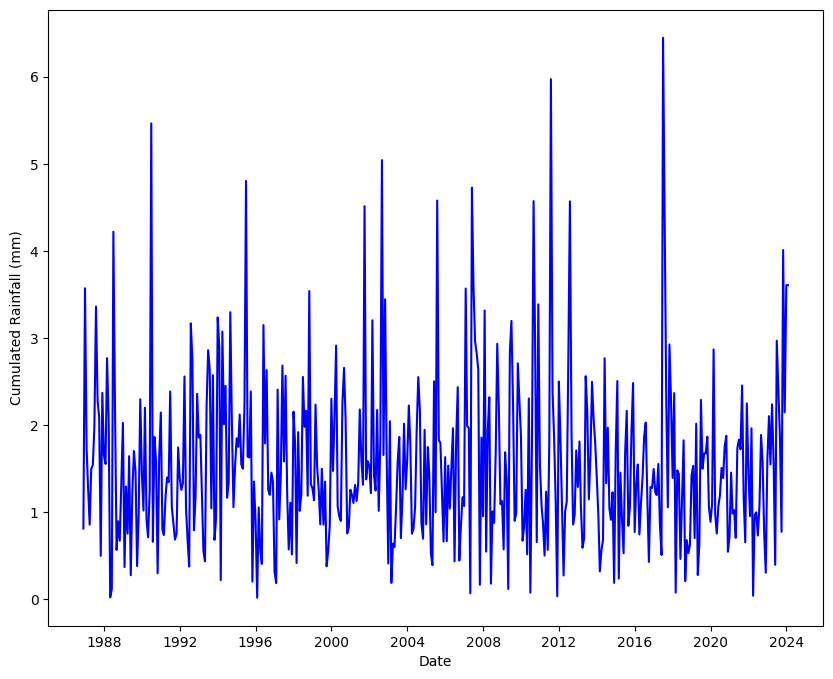

In [353]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Data
ax.plot(station_df.index, station_df["Cumulated Rainfall (mm)"], color="blue", label="Airport")

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Cumulated Rainfall (mm)")

plt.show()


In [354]:
# final overview of the data
station_df.describe()

Air Temperature (°C)  ...  Cumulated Rainfall (mm)
count            447.000000  ...               447.000000
mean              11.260376  ...                 1.559751
std                8.178845  ...                 0.970241
min               -8.000000  ...                 0.019355
25%                4.000000  ...                 0.893495
50%               11.000000  ...                 1.393548
75%               18.000000  ...                 2.027419
max               31.400000  ...                 6.446667

[8 rows x 10 columns]

In [355]:
# Let's save the final DataFrame for future notebooks
station_df.to_excel(
    os.path.join(data_path, "clean_data.xlsx")
)

# Linear Regression

We can now start performing linear regression on historical data to predict our target variable (DOC (mg/l)) with respect to the regressors. 

We are going to use the [statsmodels](https://www.statsmodels.org/stable/index.html) package as it provides more insights for linear regression tasks.

In [356]:
# import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

First of all, we need to normalize our exogenous variables to ensure better convergence of OLS, since there is a high difference in the scale of their domains.


In [357]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

In [358]:
# fit the model
X_train_scaled = sm.add_constant(X_train_scaled)

model = sm.OLS(y_train, X_train_scaled).fit()

In [359]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
X_test_scaled = sm.add_constant(X_test_scaled)

# make predictions
y_pred = model.predict(X_test_scaled)

To evaluate the quality of our regression we can analyse some metrics:

**Residual Sum of Squares**

$RSS = \sum_n (\hat{t}_n-t_n)^2$, it tells us how much of the prediction differs from the true value.

In [360]:
RSS = np.sum((y_test - y_pred) ** 2)
RSS

np.float64(79.31645731577777)

**(Adjusted) Coefficient of determination**



$R^2_{\text{adj}} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)$, where $R^2 = 1 - \frac{RSS}{\sum_n (\bar{t}-t_n)^2}$. It is a modified version of $R^2$ that accounts for the number of predictors (independent variables) in the model. It penalizes the inclusion of unnecessary variables that do not improve the model significantly.

$R^2 = 1 - \frac{RSS}{\sum_n (\bar{t}-t_n)^2}$, it tells us how the fraction of the variance of the data explained by the model (how much better we are doing w.r.t. just using the mean of the target $\bar{t} = \frac{\sum_n t_n}{N}$).

In spaces with a single feature this is equal to the correlation coefficient between the input and the output;

For a more detailed explanation: https://en.wikipedia.org/wiki/Coefficient_of_determination

Statsmodels offers a summary with a lot of information, including $R^2$ and $R^2_{\text{adj}}$.

In [361]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     12.78
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.36e-17
Time:                        16:23:53   Log-Likelihood:                -498.36
No. Observations:                 357   AIC:                             1017.
Df Residuals:                     347   BIC:                             1056.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

**Mean Squared Error**

$MSE = \frac{\sum_n (\hat{t}_n-t_n)^2}{N}$, it tells approximately how much error we get on a predicted data over the training set (i.e., a normalized version of the RSS).

In [362]:
from sklearn.metrics import mean_squared_error

In [363]:
mean_squared_error(y_test, y_pred)

np.float64(0.8812939701753085)

We can see how the standard linear regression doesn't perform quite well since it makes the strong assumption of linear dependencies between the target variable and the features, which in real-world problems it is usually not the case.

More complex models able to capture non-linear relationships are often used. However, understanding which model is best suited for a specific problem is not straightforward. The process of model selection involves different tasks, from feature selection to hyperparameter tuning. Here a first naive comparison between different models is performed.

The models we are going to compare are:
- Linear Regression
- Random Forest
- Multi-layer Perceptron Neural Network
- XGBoost

Since Random Forest, MLP and XGBoost are non-deterministic types of models, to evaluate them we are going to use cross-validation to reduce the impact of randomness of these models.

# Model Comparison

In [364]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

In [365]:
# save the linear regression results
y_pred_lr = y_pred.copy()    

In [366]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

In [367]:
# perform cross validation for the different models

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Neural Network
nn_model = MLPRegressor(max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

/Users/massimilianoarca/Documents/PoliMi/Research Grant/PhD Course/ml-practical-sessions/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [368]:
# predict on the test set

# Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)

# Neural Network
y_pred_nn = nn_model.predict(X_test_scaled)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)

Linear Regression MSE: 0.8812939701753085
Random Forest MSE: 0.8650241493274708
Neural Network MSE: 0.8454716625001006
XGBoost MSE: 0.9845919597234262


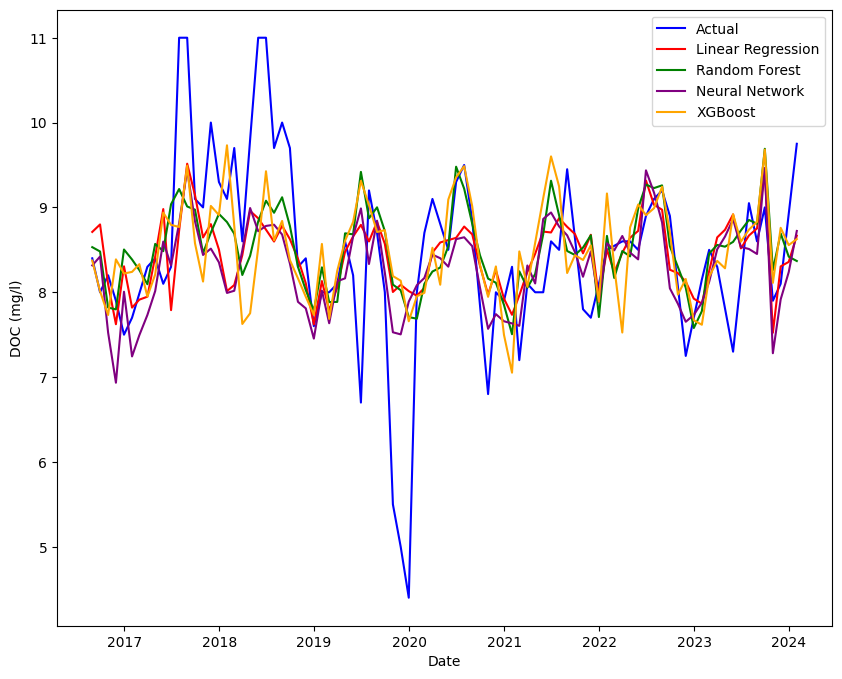

In [369]:
# compare the results

# Linear Regression
print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred_lr)}")

# Random Forest
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf)}")

# Neural Network
print(f"Neural Network MSE: {mean_squared_error(y_test, y_pred_nn)}")

# XGBoost
print(f"XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb)}")

fig, ax = plt.subplots(figsize=(10, 8))

# Plot Data
ax.plot(y_test.index, y_test, color="blue", label="Actual")
ax.plot(y_test.index, y_pred_lr, color="red", label="Linear Regression")
ax.plot(y_test.index, y_pred_rf, color="green", label="Random Forest")
ax.plot(y_test.index, y_pred_nn, color="purple", label="Neural Network")
ax.plot(y_test.index, y_pred_xgb, color="orange", label="XGBoost")

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("DOC (mg/l)")
ax.legend()

plt.show()

In [370]:
# Let's see the training errors for the different models to see if they are overfitting or underfitting

# Linear Regression
y_pred_train_lr = model.predict(sm.add_constant(X_train_scaled))

# Random Forest
y_pred_train_rf = rf_model.predict(X_train_scaled)

# Neural Network
y_pred_train_nn = nn_model.predict(X_train_scaled)

# XGBoost
y_pred_train_xgb = xgb_model.predict(X_train_scaled)

In [371]:
# compare the results

# Linear Regression
print(f"Linear Regression MSE: {mean_squared_error(y_train, y_pred_train_lr)}")

# Random Forest
print(f"Random Forest MSE: {mean_squared_error(y_train, y_pred_train_rf)}")

# Neural Network
print(f"Neural Network MSE: {mean_squared_error(y_train, y_pred_train_nn)}")

# XGBoost
print(f"XGBoost MSE: {mean_squared_error(y_train, y_pred_train_xgb)}")

Linear Regression MSE: 0.9551203100885723
Random Forest MSE: 0.13965020915614063
Neural Network MSE: 1.012478211245864
XGBoost MSE: 1.1362525958565577e-05


Especially for the Random Forest and XGBoost models, we have a training error << test error, meaning these models are probably overfitting the training set cannot generalize on the test set.
Regarding linear regression, we have a training error similar to the test error. This suggests low variance and low bias, meaning the model is not overfitting or underfitting. It is not the most powerful model, but it generalizes well.
As for the Neural Network, the errors are close, meaning the model generalizes well. There’s a slight underfitting (train error is higher than test error), but it's not severe. This suggests the model could benefit from longer training (increase max_iter) or more hidden layers/neurons.